In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import gseapy as gp
import scvelo as scv
from tqdm.auto import tqdm
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = config['data_path']
# local utils
sys.path.insert(1, '../utils/')
from utils import score_hallmarks, specify_genes, rsum, cluster_matrix
from utils import score_genes, get_ribo_percentage, plot_differential_test
from utils import run_progeny, obs_obs_aggregate_heatmap

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

# Loading

In [2]:
# Cached loading of macro data
cached = data_path / "Pancov19_prepd_endos.h5"
if cached.is_file():
    mdata = sc.read(cached)
else:
    # Load data
    mdata = sc.read(data_path / "Cov19Hamster_timecourse_integrated_endothelial.h5")
    mdata.obs['SCoV2_detected'] = mdata.obs['SCoV2_sum'] > 0
    # combined annotations for convenience
    mdata.obs['organism_time'] = [o+'_'+t for o, t in zip(mdata.obs['organism'], mdata.obs['time'])]
    mdata.obs['organism_dosage'] = [o+'_'+d for o, d in zip(mdata.obs['organism'], mdata.obs['dosage'])]
    mdata.obs['organism_dosage_time'] = [o+'_'+d+'_'+t for o, d, t in zip(mdata.obs['organism'], mdata.obs['dosage'], mdata.obs['time'])]

    # filter genes to be expressed in at least a few cells and have at least a few counts in total
    limit_cells = (rsum(mdata.layers['counts']>0, axis=0) > 20)
    limit_counts = rsum(mdata.layers['counts'], axis=0) > 100
    mdata = mdata[:, limit_cells & limit_counts].copy()
    print('AnnData shape:', mdata.shape)

    # score progeny
    import decoupler as dc
    model = dc.get_progeny(organism='mouse', top=100)
    dc.run_mlm(mat=mdata, net=model, source='source', target='target', weight='weight', verbose=True, use_raw=False)
    for key in mdata.obsm['mlm_estimate'].columns: mdata.obs[f'{key}_progeny'] = mdata.obsm['mlm_estimate'][key]
    prokeys = [x for x in mdata.obs.keys() if 'progeny' in x]
    
    # score hallmarks
    score_hallmarks(mdata, 'all', species='mouse')
    
    # custom scores
    kegg_rigI='TANK,CHUK,MAPK14,CYLD,DDX3X,DDX58,TKFC,TBK1,IFNE,STING1,IFNA1,IFNA2,IFNA4,IFNA5,IFNA6,IFNA7,IFNA8,IFNA10,IFNA13,IFNA14,IFNA16,IFNA17,IFNA21,IFNB1,IFNW1,IKBKB,CXCL8,IL12A,IL12B,CXCL10,IRF3,IRF7,MAP3K1,NFKB1,NFKBIA,NFKBIB,PIN1,RNF125,OTUD5,MAPK8,MAPK11,MAPK9,MAPK10,MAPK13,IFNK,MAVS,RELA,MAPK12,IFIH1,AZI2,MAP3K7,TNF,TRAF2,TRAF3,TRAF6,TRIM25,DHX58,NLRX1,SIKE1,CASP8,CASP10,IKBKG,DDX3Y,TRADD,RIPK1,FADD,ATG12,ATG5,ISG15,IKBKE,TBKBP1'.split(',')
    genes = pd.unique(list(specify_genes(kegg_rigI, 'human', 'mouse')))
    sc.tl.score_genes(mdata, genes, score_name='kegg_rigI_score')

    # set times
    mdata.obs['time_num'] = [int(x[1:]) for x in mdata.obs.time]
    times = pd.unique(mdata.obs['time_num'])
    time_dict = dict(zip(times, np.arange(len(times))))
    mdata.obs['time_order'] = [time_dict[x] for x in mdata.obs.time_num]
    mdata.write(cached)

mdata.obs['replicate'] = [x[2] for x in mdata.obs.hamster]

In [3]:
# Import color options
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']
endo_colors = config['endo_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
    return s.replace('_', ', ')

# Capitalized obs keys are "sanitized" ones (i.e. mapped to new names)
for key in ['dosage', 'time', 'organism', 'organism_dosage', 'organism_dosage_time', 'organism_time']:
    mdata.obs['_'.join([x.capitalize() for x in key.split('_')])] = [sanitize_name(s) for s in mdata.obs[key]]

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1-0.00000001),
              }

mdata.uns['celltype_colors'] = [endo_colors[x] for x in mdata.obs['celltype'].unique()]
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(mdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in mdata.obs.organism_dosage_time.unique() if 'D0' not in x}

# Special Genes and pathways

Done these:
- cell cycle along DC4 (did not see much)
- Markus favs: genes = ['Arid5a', 'Tcim', 'Sav1', 'Lgals8', 'Lgals9', 'Lgals3bp', 'Atf3', 'Cdkn1a', 'Plaur', 'Litaf', 'Irf9', 'Socs1', 'Myct1', 'Adgrl3', 'Wwtr1']
- ...

## Cherry-picked Timecourses

In [ ]:
cherry = 'Lifr,Adgrl3,Ano6,Ptprb,Gch1,Atf3,Psmb10,Ido1,Adm,Lgals9,Mnda,Dhx58,Ddx58,Isg20,Slfn5,Socs1,Il15ra,Irf9,Ly6e,Bst2,Nlrc5,Ccrl2,Csf1,Lamp2,Pglyrp1,Lyve1,Hspb8,Rgcc,Hmox1,Fgfrl1,Setx,Socs3,Max,\
Icam1,Nfkbia,Cd63,Socs2,Cxcl16,Lgals8,Litaf,Cxcl10,Rsad2,Mx2,Ccl5,Ccl8,Serping1,Irf7,Ifit2,Ifit3,Cmpk2,Herc6,Isg15,Usp18,Ube2l6'.split(',')

In [157]:
# endos
endo_tc_genes = [  # run4
    'Lamp2',
    'Lgals9',
    'Hilpda',
    'Marcksl1',
    'Hspb8',
    'ND4L',
    'Lifr',  # lif
    'Max',
    'Adgrl4',
    'Adgrl3',
    'Socs2',
    'Timp1',
    'Rpl32'
] + [  # run3
    'Isg20',
    'Tcim',
    'Hmox1',
    'Hrct1',
    'Ptprb',
    'Calm2',
    'Wwtr1',
    'Slfn5',
    'Synm',
    'Eln'
] + [  # run2
    'Irf7',
    'Nol12',
    'Ano6',
    'Lap3',
    'Irf9',
    'Dtx3l',
    'Cd34',
    'Tmbim6',
    'Stat2',
    'Ido1',
    'Hyal2',
    'Rad23a',
    'Lyve1',
    'Ubxn2a',  # lif
    'Ifit2',
    'Nub1',
    'Rsad2',
    'Nop10',
    'Setx',
    'Med10',
    'Xdh',
    'Spats2l',
    'Psmb10',
    'Socs3',
    'Elovl5',
    'Ogfr',
    'Pdlim7',
    'Slc3a2',
    'Litaf',
    'Ddit3',
    'Upp1',
    'Isg15',
    'Bbc3',
    'Sav1',
    'Tinagl1',
    'Gadd45g',
    'Thbs1',
    'Sema7a',
    'Slc35f5',
    'Arl4a',
    'Rgcc',
    'Scgb1a1',
    'Atf3'
] + [  # run1 dwarfd2
    'Lgals3bp',
    'Irf7',
    'Herc6',
    'Hyal2',
    'Usp18',
    'Ube2l6',
    'Xaf1',
    'Ucp2',
    'Nmi',
    'Shisa5',
    'Bst2',
    'Ehd1',
    'Psmb8',
    'Wars1',
    'Ddx58',
    'Trim21',
    'Mx2',
    'Ifih1',
    'Rnf213',
    'Dll1',
    'Serping1',
    'Cmpk2',
    'Ccrl2',
    'Setx',
    'Socs1',
    'Tap1',
    'Ly6e',
    'Helz2',
    'Rtp4',
    'Cxcl16',
    'Uba7',
    'Ccl5',
    'Parp12',
    'Ogfr',
    'Gch1',
    'Trafd1',
    'Rnf114',
    'Parp14',
    'Pald1',
    'Tlnrd1',
    'Clic4',
    'Ifit3',
    'Nlrc5',
    'Tap2',
    'Tsc22d3',
    'Dhx58',
    'Icam1',
    'Eif2ak2',
    'Csf1',
    'Parp9',
    'Atad1',
    'Pml',
    'Cxcl10',
    'Samd9',
    'Parp10',
    'Hpcal1',
    'Nampt',
    'Cdkn1a',
    'Acot7',
    'Rassf1',
    'Yars1',
    'Myct1',
    'Shfl',
    'Fads3',
    'Ccl8',
    'Cmtr1',
    'Ddah2',
    'Rbm43',
    'Btg3',
    'Arid5a',
    'Mitd1',
    'Fgfrl1',
    'Sars1',
    'Slc25a28',
    'Sav1',
    'Lgals8',
    'Gpr146',
    'Edem1',
    'Ddx60',
    'Ddit4',
    'Il15ra',
    'Irf9',
    'Cd63',
    'Adgrg1',
    'Sox4',
    'Nfkbia',
    'Zcchc2',
    'Dynlt1',
    'Sh3bp5',
    'Adm',
    'Rras2',
    'Ybx3',
    'Ppp1r18',
    'Arl4a',
    'Plaur',
    'Cebpd',
    'Aldh2',
    'Hopx',
    'Ltc4s',
    'Ppp1r15a',
    'Gng11',
    'Spats2l',
    'Ifrd1',
    'Pglyrp1',
    'Pdlim7',
    'Itga3',
    'Cxcl12',
    'Azi2',
    'Sqstm1',
    'Mnda',
    'Atf3',
    'Sema7a',
    'Myc',
    'Thbs1',
    'Klf6',
] + [  # dwarfd3
    'Gclm',
    'Atf5'
]

endo_tc_genes = pd.unique(endo_tc_genes)

In [7]:
# Dwarf D2 and Gold D5 initial response
s1='Hilpda,Max,Timp1,Isg20,Ptprb,Nol12,Ano6,Tmbim6,Ido1,Hyal2,Rad23a,Lyve1,Psmb10,Socs3,Pdlim7,Slc3a2,Litaf,Ddit3,Upp1,Sema7a,Slc35f5,Arl4a,Atf3,Socs1,Gch1,Pald1,Atad1,Cxcl10,Parp10,Hpcal1,Rassf1,Sars1,Slc25a28,\
Gpr146,Adgrg1,Ppp1r18,Plaur,Hopx,Itga3,Sqstm1,Myc'.split(',')
# Response in both at D2
s2='Lamp2,Calm2,Wwtr1,Irf7,Irf9,Cd34,Stat2,Ifit2,Rsad2,Xdh,Ogfr,Isg15,Tinagl1,Gadd45g,Lgals3bp,Herc6,Usp18,Ube2l6,Nmi,Shisa5,Bst2,Psmb8,Mx2,Ifih1,Serping1,Ly6e,Helz2,Rtp4,Ccl5,Clic4,Ifit3,Tsc22d3,Ccl8,\
Ddit4,Sox4,Ltc4s,Irfd1,Pglyrp1,Cxcl12,Mnda'.split(',')
# Sharp response in Dwarf and slow response in Gold
s3='Lgals9,Lifr,Socs2,Slfn5,Synm,Dtx3l,Nub1,Spats2l,Thbs1,Ddx58,Trim21,Rnf213,Cmpk2,Ccrl2,Tap1,Cxcl16,Uba7,Parp12,Trafd1,Rnf114,Parp14,Nlrc5,Tap2,Dhx58,Eif2ak2,Csf1,Parp9,Pml,Nampt,Myct1,Cmtr1,Rbm43,Arid5a,\
Mitd1,Lgals8,Ddx60,Il15ra,Zcchc2,Dynlt1,Adm,Azi2,Atf5'.split(',')
# other (e.g. opposite response)
s4='Marcksl1,Hspb8,ND4L,Adgrl4,Adgrl3,Rpl32,Tcim,Hmox1,Hrct1,Eln,Lap3,Ubxn2a,Nop10,Setx,Med10,Elovl5,Bbc3,Sav1,Rgcc,Scgb1a1,Xaf,Ucp2,Ehd1,Wars1,Dll1,Tlnrd1,Icam1,Samd9,Cdkn1a,Acot7,Yars1,Shfl,Fads3,Ddah2,Btg3,\
Fgfrl1,Edem1,Cd63,Nfkbia,Sh3bp5,Cebpd,Aldh2,Ppp1r15a,Gng11,Klf6,Gclm'.split(',')
# Only response in Dwarf
s5='Rras2,Ybx3'.split(',')

## Hallmarks and Progeny

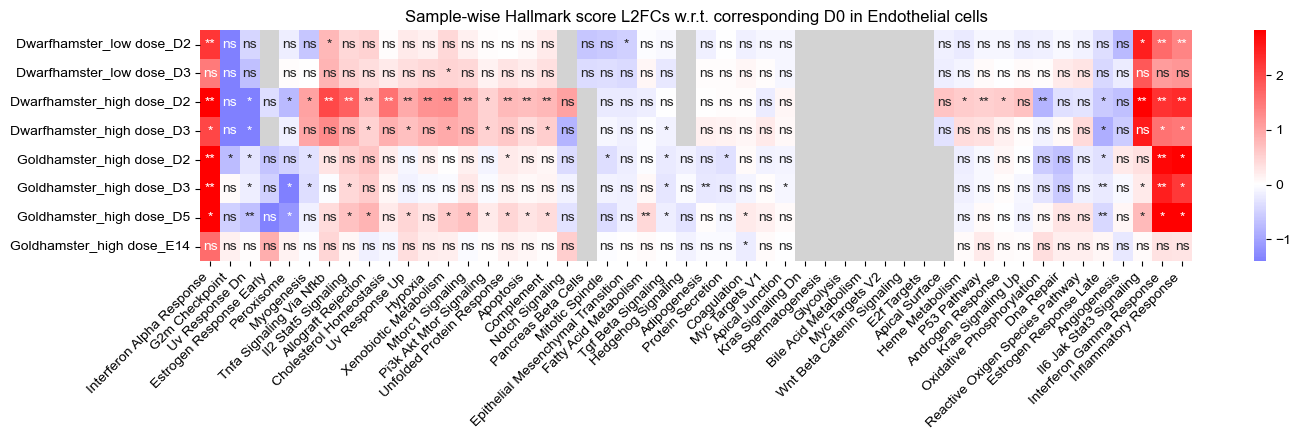

In [213]:
fig, ax = pl.subplots(figsize=[16,3], dpi=100)
ax = plot_differential_test(mdata, hallmarks, 'organism_dosage_time', cluster='col',
                       control=control_dict_odt, replicate_key='orig.ident', 
                       show=False)
labels = [item.get_text() for item in ax.get_xticklabels()] 
pl.xticks(np.arange(len(labels))+0.5, 
          [' '.join([y.capitalize() for y in x.replace('HALLMARK_', '').split('_')]) for x in labels], 
          rotation=45, ha='right')
pl.title('Sample-wise Hallmark score L2FCs w.r.t. corresponding D0 in Endothelial cells')
pl.savefig(figure_path / f'Hallmarks_l2fcs.pdf', bbox_inches='tight')
pl.show()

## KEAP1-NFE2L2 pathway

In [231]:
reactome = read_gmt(Path(signatures_path) / "enrichr_libraries/ReactomePathways_2022_Human.gmt")
nfe2l2_sig = np.intersect1d(sdata.var_names, specify_genes(reactome['REACTOME_KEAP1_NFE2L2_PATHWAY'], 'human', 'mouse'))
nfe2l2_2_sig = np.intersect1d(sdata.var_names, specify_genes(reactome['REACTOME_NUCLEAR_EVENTS_MEDIATED_BY_NFE2L2'], 'human', 'mouse'))

In [237]:
genes = list(np.unique(np.hstack([nfe2l2_sig, nfe2l2_2_sig])))

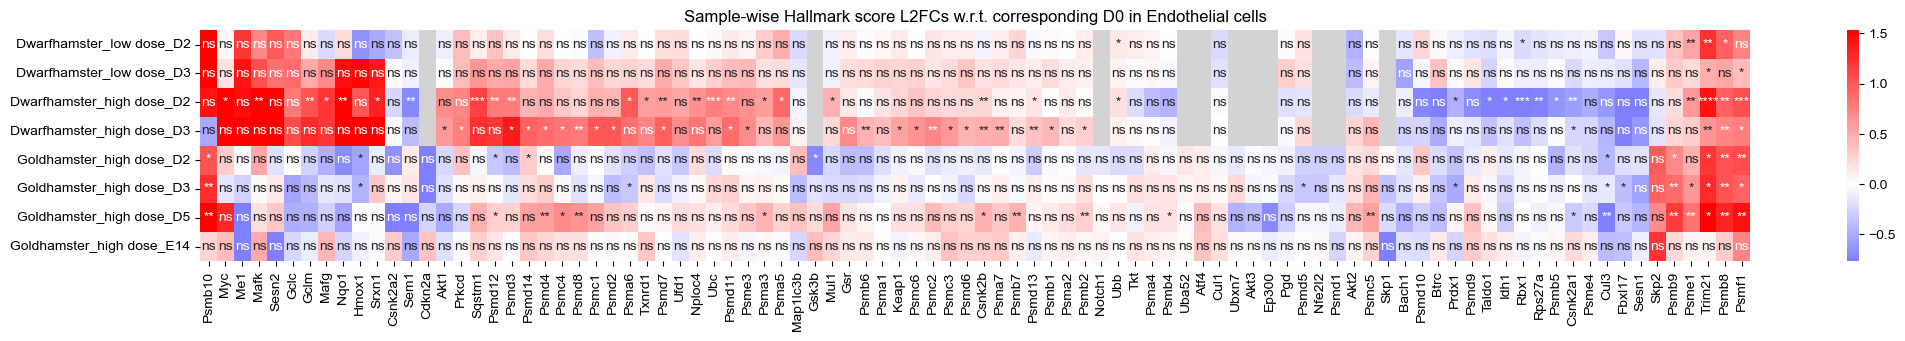

In [238]:
fig, ax = pl.subplots(figsize=[25,3], dpi=100)
ax = plot_differential_test(mdata, genes, 'organism_dosage_time', cluster='col',
                       control=control_dict_odt, replicate_key='orig.ident', 
                       show=False)
pl.title('Sample-wise L2FCs w.r.t. corresponding D0 in Endothelial cells')
# pl.savefig(figure_path / f'Hallmarks_l2fcs.pdf', bbox_inches='tight')
pl.show()

## Old stuff mixed

warn me?


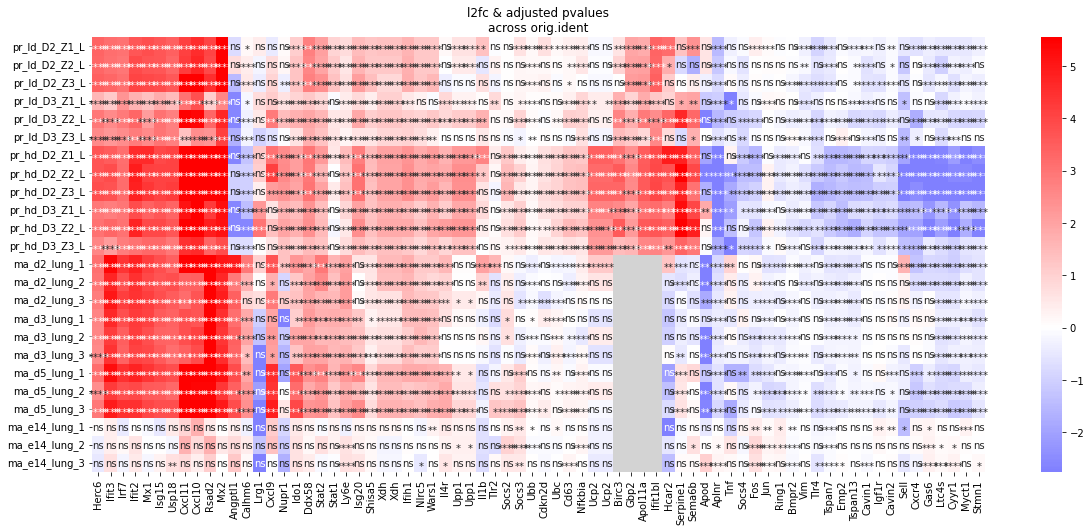

In [322]:
special_genes = {
    'chemoattractant-receptors': ['Cxcr4'],
    'activating inflammation factors': ['Tnf', 'Il1b'],
    'PRRs': ['Tlr2', 'Tlr4', 'Ddx58', 'Ifih1'],  # Ddx58 is RIG-I, Ifih1 is MDA-5
    'NOD-like PRRs': ['Nlrc5'],
    'activation +': ['Cd63'], # Fcgr1 is Cd64, Itgam is Cd11b, Ceacam1 is Cd66
    'activation -': ['Sell'],  # Sell is Cd62l, Cxcr2 is Cd182
    'Oxidative stress': 'Jun, Fos, Ring1, Cdkn2d, Ubb, Ubc'.split(', '),
    'Zheng et al': 'Lrg1, Cxcl9, Serpine1, Aplnr, Apod, Acod1,Il1a, Sema6b, Hcar2, Angptl1'.split(', '),
    #'hallmarks': ['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INFLAMMATORY_RESPONSE'],
    'SOCS': 'Stat1, Stat2, Soc1, Socs2, Socs3, Socs4, Il4r, Igf1r'.split(', '),
    'From DEtests': 'Calhm6, Ly6e, S1008a, Wars1, Ido1, Ucp2, Upp1, Xdh, Nupr1'.split(', '),
    'Core infection': 'Isg15 Isg20 Rsad2 Cxcl11 Usp18 Cxcl10 Irf7 Ifit2 Ifit3 Xdh Apol11a Upp1 Ucp2 Herc6 Mx2 Mx1 Nfkbia Birc3 Gbp2 Ifit1bl Shisa5'.split(' '),
    'Core anti-infection': 'Myct1 Gas6 Cyyr1 Emp2 Stmn1 Ltc4s Bmpr2 Cavin1 Cavin2 Vim Tspan7 Tspan13'.split(' '),
}
# genes = np.sum([[x for x in v if x in mdata.var_names or x in mdata.obs.keys()] for v in special_genes.values()])
pl.figure(figsize=[20,8])
plot_differential_test(mdata, special_genes, 'orig.ident', control=control_dict, sort_groups=False, cluster='col')#, vmin=-2, vmax=2

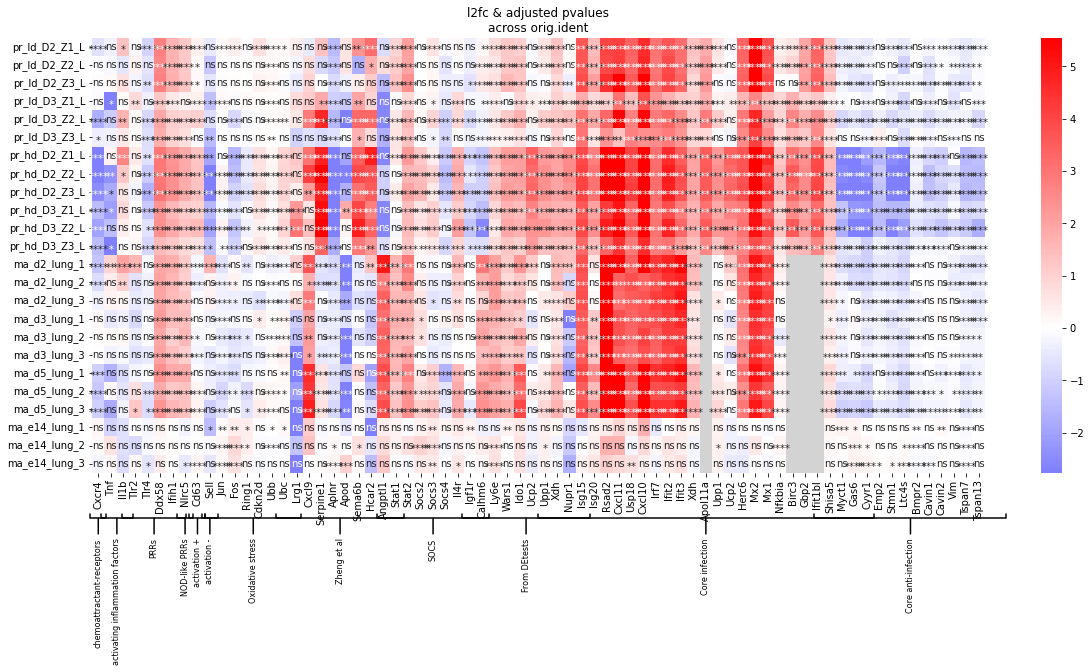

In [347]:
special_genes = {
    'chemoattractant-receptors': ['Cxcr4'],
    'activating inflammation factors': ['Tnf', 'Il1b'],
    'PRRs': ['Tlr2', 'Tlr4', 'Ddx58', 'Ifih1'],  # Ddx58 is RIG-I, Ifih1 is MDA-5
    'NOD-like PRRs': ['Nlrc5'],
    'activation +': ['Cd63'], # Fcgr1 is Cd64, Itgam is Cd11b, Ceacam1 is Cd66
    'activation -': ['Sell'],  # Sell is Cd62l, Cxcr2 is Cd182
    'Oxidative stress': 'Jun, Fos, Ring1, Cdkn2d, Ubb, Ubc'.split(', '),
    'Zheng et al': 'Lrg1, Cxcl9, Serpine1, Aplnr, Apod, Acod1,Il1a, Sema6b, Hcar2, Angptl1'.split(', '),
    #'hallmarks': ['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INFLAMMATORY_RESPONSE'],
    'SOCS': 'Stat1, Stat2, Soc1, Socs2, Socs3, Socs4, Il4r, Igf1r'.split(', '),
    'From DEtests': 'Calhm6, Ly6e, S1008a, Wars1, Ido1, Ucp2, Upp1, Xdh, Nupr1'.split(', '),
    'Core infection': 'Isg15 Isg20 Rsad2 Cxcl11 Usp18 Cxcl10 Irf7 Ifit2 Ifit3 Xdh Apol11a Upp1 Ucp2 Herc6 Mx2 Mx1 Nfkbia Birc3 Gbp2 Ifit1bl Shisa5'.split(' '),
    'Core anti-infection': 'Myct1 Gas6 Cyyr1 Emp2 Stmn1 Ltc4s Bmpr2 Cavin1 Cavin2 Vim Tspan7 Tspan13'.split(' '),
}
# genes = np.sum([[x for x in v if x in mdata.var_names or x in mdata.obs.keys()] for v in special_genes.values()])
pl.figure(figsize=[20,8])
plot_differential_test(mdata, special_genes, 'orig.ident', control=control_dict, sort_groups=False, cluster=None)#, vmin=-2, vmax=2

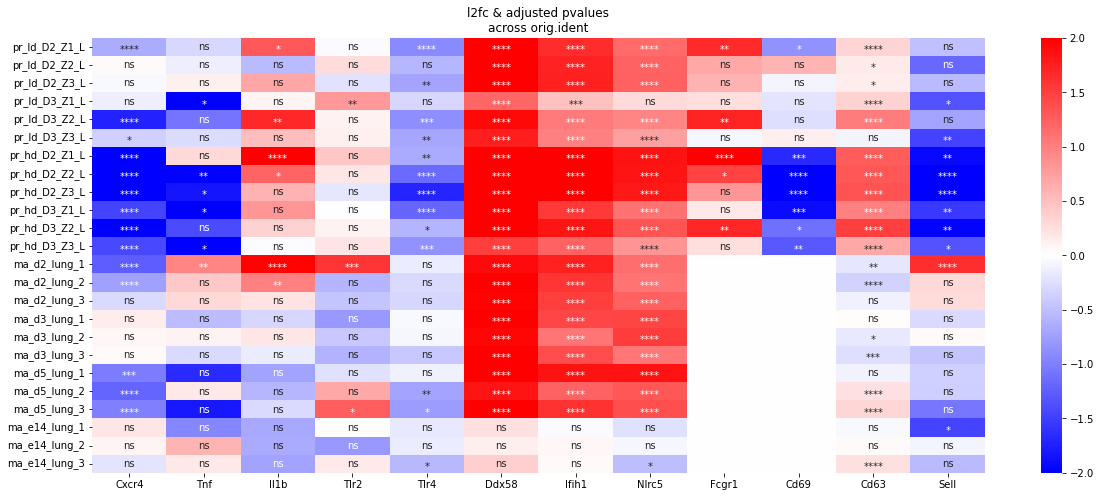

In [7]:
special_genes = {
    'chemoattractant-receptors': ['Cxcr4'],
    'activating inflammation factors': ['Tnf', 'Il1b'],
    'PRRs': ['Tlr2', 'Tlr4', 'Ddx58', 'Ifih1'],  # Ddx58 is RIG-I, Ifih1 is MDA-5
    'NOD-like PRRs': ['Nlrc5'],
    'activation +': ['Fcgr1', 'Cd69', 'Cd63'], # Fcgr1 is Cd64, Itgam is Cd11b, Ceacam1 is Cd66
    'activation -': ['Sell'],  # Sell is Cd62l, Cxcr2 is Cd182
}
genes = np.sum([[x for x in v if x in mdata.var_names] for v in special_genes.values()])
pl.figure(figsize=[20,8])
plot_differential_test(mdata, genes, 'orig.ident', control=control_dict, sort_groups=False, vmin=-2, vmax=2)

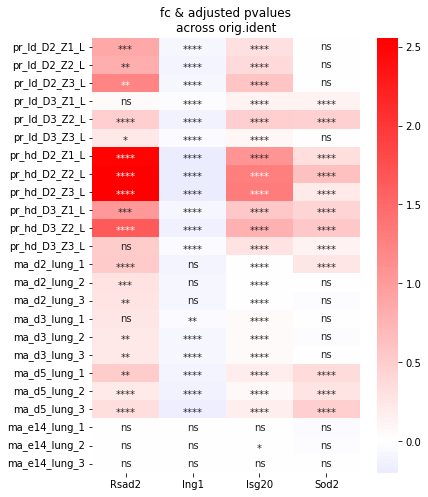

In [8]:
# up
common=['ANKRD33', 'CCNA1', 'CEP68', 'COQ2', 'E4F1', 'ENTPD7', 'FOSL1',
       'FSD1L', 'GJB6', 'GNG2', 'HPD', 'IFITM10', 'ING1', 'ISG20', 'MMP9',
       'NDUFV2', 'NEIL1', 'OXSM', 'PLOD3', 'POU2F1', 'RAB20', 'RSAD2',
       'SOD2', 'STX1B', 'SUSD3', 'TBC1D7', 'TNFSF14', 'TREML4', 'VPS18',
       'ZFP62']
common = specify_genes(common, 'human', 'mouse')

# SOD2: this protein plays an antiapoptotic role against oxidative stress, ionizing radiation, and inflammatory cytokines. [WIKI]
# RSAD2 is viral response protein

common_small = 'Ing1, Isg20, Mmp9, Rsad2, Sod2, Tnfsf14'.split(', ')
pl.figure(figsize=[6,8])
plot_differential_test(mdata, np.intersect1d(common_small, mdata.var_names), 'orig.ident', control=control_dict, sort_groups=False, change='fc', cluster='col')

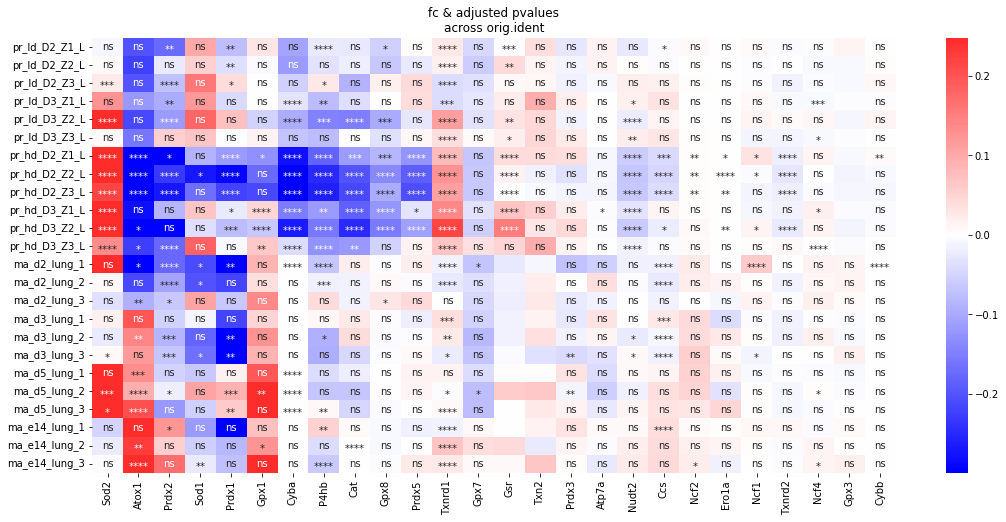

In [9]:
# Sod2 --> ROS detox superpathway (https://pathcards.genecards.org/card/detoxification_of_reactive_oxygen_species)
ros_detox='''CAT	GPX1	SOD1	GPX2	GPX3	GPX7	GSR	SOD2	SOD3	PRDX2	TXN	TXNRD1
GPX6	GPX8	NUDT2	AQP8	ATOX1	ATP7A	CYBA	CYBB	GPX5	GSTP1	NCF2	NCF4
P4HB	PRDX1	PRDX6	CCS	TXNRD2	PRDX3	PRDX5	TXN2	ERO1A	NOX4	CYCS	NOX5
NCF1	SOD2-OT1'''.replace('\n', '\t').split('\t')  # sorted (descending) by multiplicity of each gene in the constituent pathways

ros_detox = specify_genes(ros_detox, 'human', 'mouse')
ros_detox = np.array(ros_detox)[np.isin(ros_detox, mdata.var_names)]
pl.figure(figsize=[18,8])
plot_differential_test(mdata, ros_detox, 'orig.ident', control=control_dict, sort_groups=False, change='fc', cluster='col')

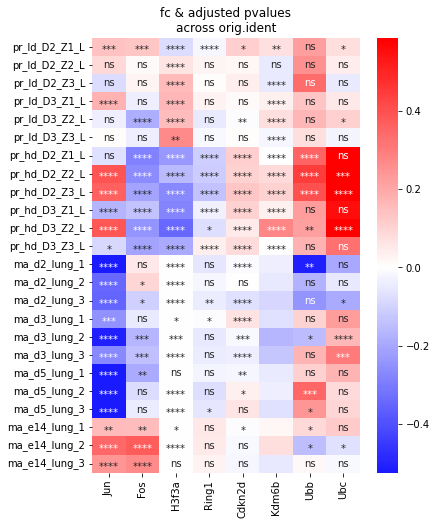

In [10]:
# Oxidative Stress Induced Senescence Pathway (https://pathcards.genecards.org/Pathway/509)
genes='''AGO1	AGO3	AGO4	BMI1	CBX2	CBX4	CBX6	CBX8
CDK4	CDK6	CDKN2A	CDKN2B	CDKN2C	CDKN2D	E2F1	E2F2
E2F3	EED	EZH2	FOS	H2AB1	H2AC14	H2AC18	H2AC19
H2AC20	H2AC4	H2AC6	H2AC7	H2AC8	H2AJ	H2AX	H2AZ1
H2AZ2	H2BC1	H2BC10	H2BC11	H2BC12	H2BC13	H2BC14	H2BC15
H2BC17	H2BC21	H2BC3	H2BC4	H2BC5	H2BC6	H2BC7	H2BC8
H2BC9	H2BU1	H3-3A	H3-3B	H3C1	H3C10	H3C11	H3C12
H3C13	H3C14	H3C15	H3C2	H3C3	H3C4	H3C6	H3C7
H3C8	H4-16	H4C1	H4C11	H4C12	H4C13	H4C14	H4C15
H4C2	H4C3	H4C4	H4C5	H4C6	H4C8	H4C9	IFNB1
JUN	KDM6B	LOC102724334	MAP2K3	MAP2K4	MAP2K6	MAP2K7	MAP3K5
MAP4K4	MAPK1	MAPK10	MAPK11	MAPK14	MAPK3	MAPK8	MAPK9
MAPKAPK2	MAPKAPK3	MAPKAPK5	MDM2	MDM4	MINK1	MIR3605	MIR4738
MIR6755	MOV10	PHC1	PHC2	PHC3	RBBP4	RBBP7	RING1
RNF2	RPS27A	SCMH1	SUZ12	TFDP1	TFDP2	TNIK	TNRC6A
TNRC6B	TNRC6C	TP53	TXN	UBA52	UBB	UBC'''.replace('\n', '\t').split('\t')  # sorted (descending) by multiplicity of each gene in the constituent pathways
genes = specify_genes(genes, 'human', 'mouse')

genes = 'Jun, Fos, Ubb, Cdkn2d, Ubc, H3f3a, Ring1, Kdm6b'.split(', ')  # selection

genes = np.array(genes)[np.isin(genes, mdata.var_names)]
pl.figure(figsize=[6,8])
plot_differential_test(mdata, genes, 'orig.ident', control=control_dict, sort_groups=False, change='fc', cluster='col')

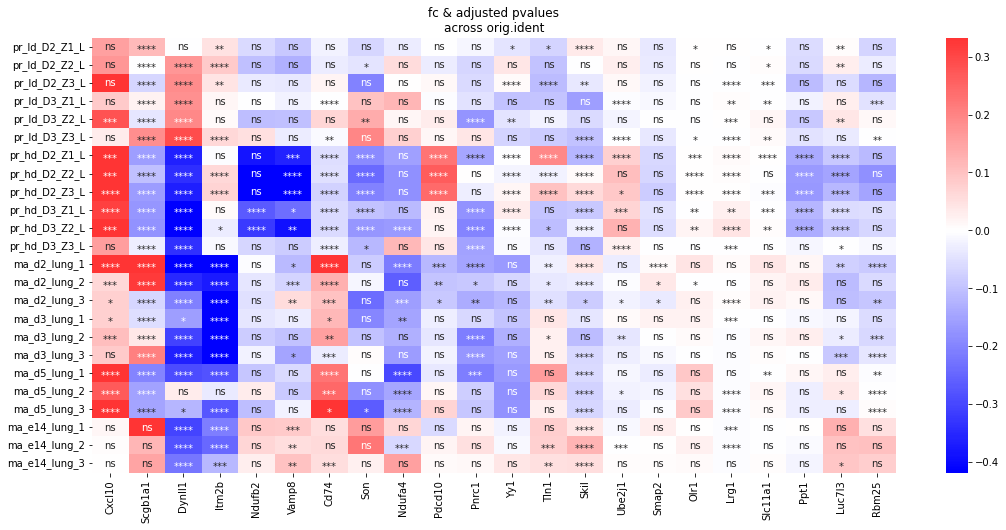

In [11]:
# down
common=['ARGLU1', 'CD74', 'COMMD6', 'CXCL10', 'DYNLL1', 'ERI1', 'FABP4',
       'FBP1', 'FKBP5', 'GSTP1', 'HNRNPA1', 'HPGD', 'IL18R1', 'IL1R2',
       'ITM2B', 'LRG1', 'LSM14A', 'LUC7L3', 'MSMB', 'NDUFA4', 'NDUFB2',
       'OLR1', 'PDCD10', 'PDIA3', 'PNRC1', 'PPIG', 'PPT1', 'PRPF40A',
       'PSME2', 'RBM25', 'RC3H1', 'RPL32', 'RPLP2', 'RWDD1', 'SCGB1A1',
       'SCGB3A1', 'SKIL', 'SLC11A1', 'SMAP2', 'SON', 'TLN1', 'TOMM7',
       'UBE2J1', 'VAMP8', 'WFDC2', 'XRCC6', 'YY1']
common = specify_genes(common, 'human', 'mouse')
common = np.array(common)[np.isin(common, mdata.var_names)]

common_small = 'Cd74, Cxcl10, Dynll1, Il1r2, Itm2b, Lrg1, Luc7l3, Ndufa4, Ndufb2, Olr1, Pdcd10, Pnrc1, Ppt1, Rbm25, Scgb1a1, Skil, Slc11a1, Smap2, Son, Tln1, Ube2j1, Vamp8, Yy1'.split(', ')
pl.figure(figsize=[18,8])
plot_differential_test(mdata, np.intersect1d(common_small, mdata.var_names), 'orig.ident', control=control_dict, sort_groups=False, change='fc', cluster='col')

In [12]:
special_genes = {
    'chemoattractant-ligands': ['Cxcl1', 'Cxcl2', 'Cxcl5','Ptafr', 'Il17a'],
    'chemoattractant-receptors': ['Cxcr1', 'Cxcr2', 'Cxcr4'],
    'activating inflammation factors': ['Tnf', 'Il1b', 'Ifng', 'Csf2'],
    'PRRs': ['Tlr1', 'Tlr2', 'Tlr4', 'Tlr5', 'Tlr6', 'Tlr7', 'Tlr8', 'Tlr9', 'Ddx58', 'Ifih1'],  # Ddx58 is RIG-I, Ifih1 is MDA-5
    'NOD-like PRRs': ['Nod1', 'Nod2', 'Nlrc5', 'Nlrx1', 'Ciita'],
    'life-span increasing': ['Ifng', 'Csf2', 'Csf3', 'Il6'],
    'activation +': ['Fcgr1', 'Itgam', 'Cd69', 'Cd63', 'Ceacam1'], # Fcgr1 is Cd64, Itgam is Cd11b, Ceacam1 is Cd66
    'activation -': ['Sell', 'Cxcr2'],  # Sell is Cd62l, Cxcr2 is Cd182
    'others': ['Anxa1', 'Cxcl12']
}

In [13]:
# selection
sgenes = ['Cxcl2', 'Ptafr', 'Cxcr2', 'Cxcr4', 'Tnf', 'Il1b', 'Tlr2', 'Tlr4', 'Ddx58', 'Ifih1', 'Nod2', 'Nlrc5', 'Fcgr1', 'Itgam', 'Cd69', 'Cd63', 'Ceacam1', 'Sell', 'Anxa1']
sgenes = np.intersect1d(sgenes, mdata.var_names)

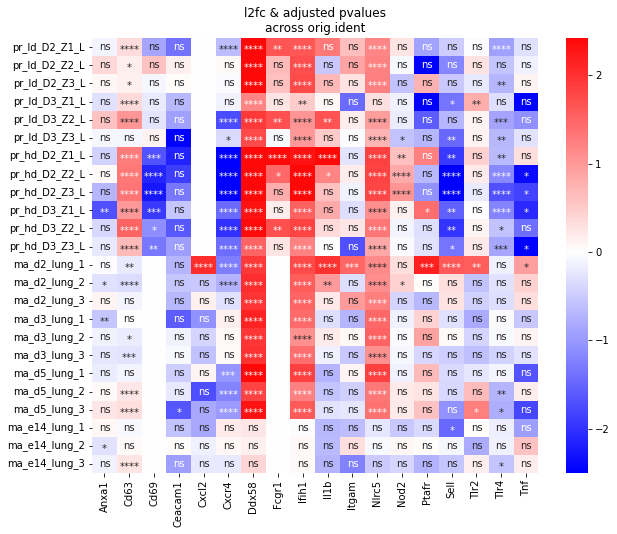

In [14]:
pl.figure(figsize=[10,8])
plot_differential_test(mdata, sgenes, 'orig.ident', control=control_dict, sort_groups=False)

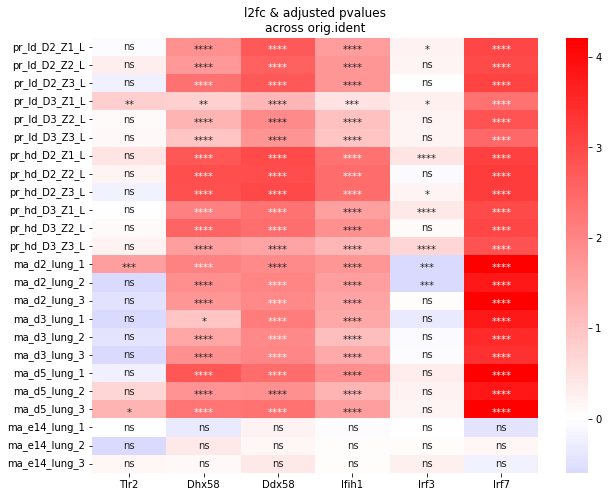

In [15]:
# RIG-I-like receptor pathway (https://www.nature.com/articles/s41577-020-0288-3/figures/2)
# venes = ['Dhx58', 'Mavs', 'Tbk1', 'Ikbke', 'Irf3', 'Irf7', 'Nfkb1', 'Ifnb1']  # Dhx58 is Lgp2
venes = ['Tlr2', 'Dhx58', 'Ddx58', 'Ifih1', 'Irf3', 'Irf7']
pl.figure(figsize=[10,8])
plot_differential_test(mdata, venes, 'orig.ident', control=control_dict, sort_groups=False)

In [16]:
tab = pd.read_excel('../metadata/Zheng_et_al_Table2.xlsx', sheet_name=0, skiprows=1)

In [17]:
all_zheng = tab.gene_name[np.isin(tab.gene_name, mdata.var_names)]   # Table S2.DEG for twice Bulk RNA-Seq (cov vs non-cov?)

In [18]:
len(all_zheng)

185

In [19]:
pval_adj_tab, l2fc_tab, fc_tab = differential_test(mdata, all_zheng, 'organism_dosage_time', control=control_dict_odt, sort_groups=False)

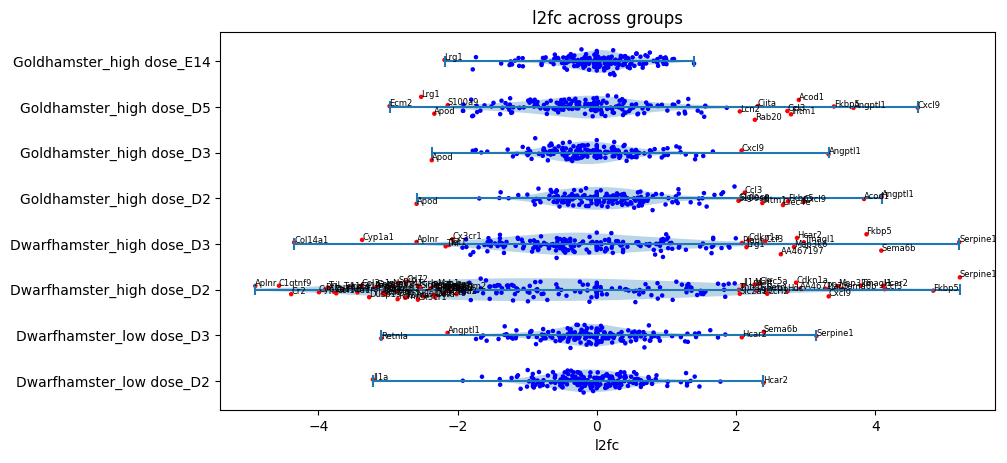

In [20]:
DEviolin(l2fc_tab, figsize=[10, 5], dpi=100, cutoff=2)

## PRRs and RIG-I

- Yamada, T., Sato, S., Sotoyama, Y. et al. RIG-I triggers a signaling-abortive anti-SARS-CoV-2 defense in human lung cells. Nat Immunol 22, 820–828 (2021). https://doi.org/10.1038/s41590-021-00942-0
- Rehwinkel, J., Gack, M.U. RIG-I-like receptors: their regulation and roles in RNA sensing. Nat Rev Immunol 20, 537–551 (2020). https://doi.org/10.1038/s41577-020-0288-3

In [30]:
kegg_rigI='TANK,CHUK,MAPK14,CYLD,DDX3X,DDX58,TKFC,TBK1,IFNE,STING1,IFNA1,IFNA2,IFNA4,IFNA5,IFNA6,IFNA7,IFNA8,IFNA10,IFNA13,IFNA14,IFNA16,IFNA17,IFNA21,IFNB1,IFNW1,IKBKB,CXCL8,IL12A,IL12B,CXCL10,IRF3,IRF7,MAP3K1,NFKB1,NFKBIA,NFKBIB,PIN1,RNF125,OTUD5,MAPK8,MAPK11,MAPK9,MAPK10,MAPK13,IFNK,MAVS,RELA,MAPK12,IFIH1,AZI2,MAP3K7,TNF,TRAF2,TRAF3,TRAF6,TRIM25,DHX58,NLRX1,SIKE1,CASP8,CASP10,IKBKG,DDX3Y,TRADD,RIPK1,FADD,ATG12,ATG5,ISG15,IKBKE,TBKBP1'.split(',')
genes = pd.unique(list(specify_genes(kegg_rigI, 'human', 'mouse')))
sc.tl.score_genes(mdata, genes, score_name='kegg_rigI_score')

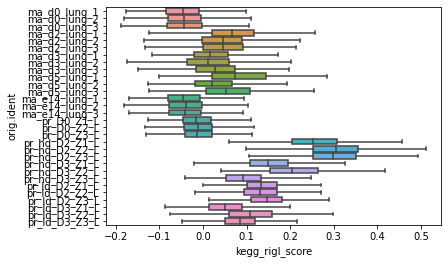

In [31]:
sns.boxplot(data=mdata.obs, y='orig.ident', x='kegg_rigI_score', showfliers=False);

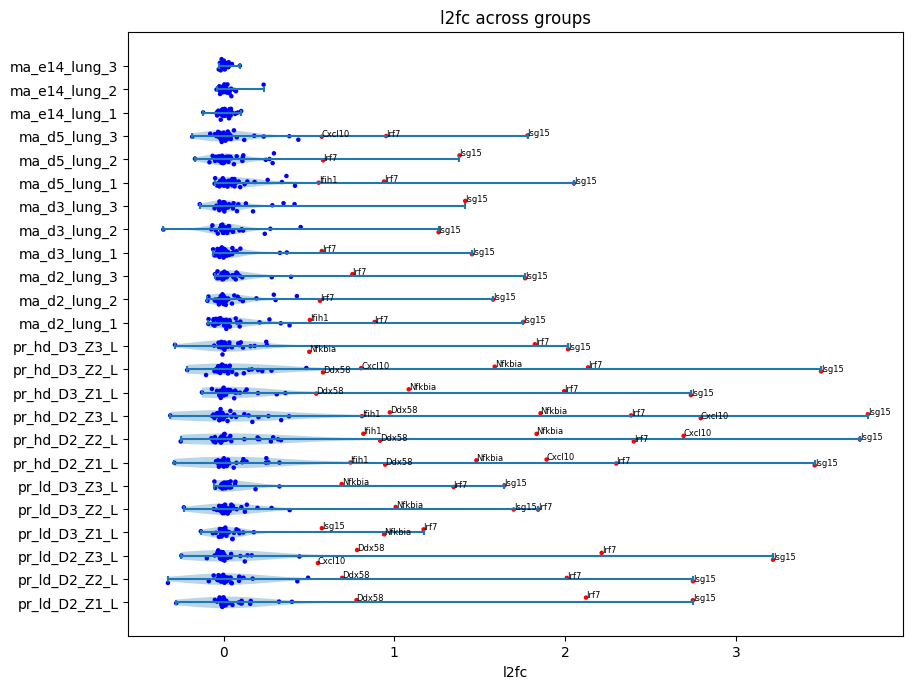

In [32]:
genes = [x for x in genes if x in mdata.var_names]
l2fc_tab = differential_test(mdata, genes, 'orig.ident', control=control_dict, sort_groups=False)[-1]
DEviolin(l2fc_tab, figsize=[10,8], dpi=100, cutoff=0.5, show=True)

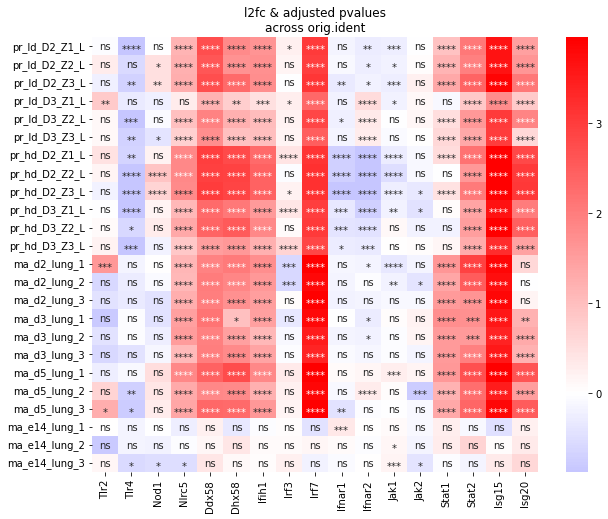

In [33]:
# PRRs --> TFs --> Type 1 Inferferon --> Interferon Type 1 receptors --> JAK-STAT --> Transcription of ISGs
genes = [
    'Tlr2', 'Tlr4',  # Toll-like receptors (PRRs)
    'Nod1', 'Nlrc5',  # NOD-like PRRs
    'Ddx58', 'Dhx58', 'Ifih1',  # Ddx58 is RIG-I, Ifih1 is MDA-5
    'Irf3', 'Irf7',  # downstream_TFs of RIG-I/MDA-5
    'Ifnar1', 'Ifnar2',  # IFNa receptors
    'Jak1', 'Jak2', 'Stat1', 'Stat2', # JAK-STAT
    'Isg15', 'Isg20'  # ISGs
]

pl.figure(figsize=[10,8])
plot_differential_test(mdata, genes, 'orig.ident', control=control_dict, sort_groups=False)

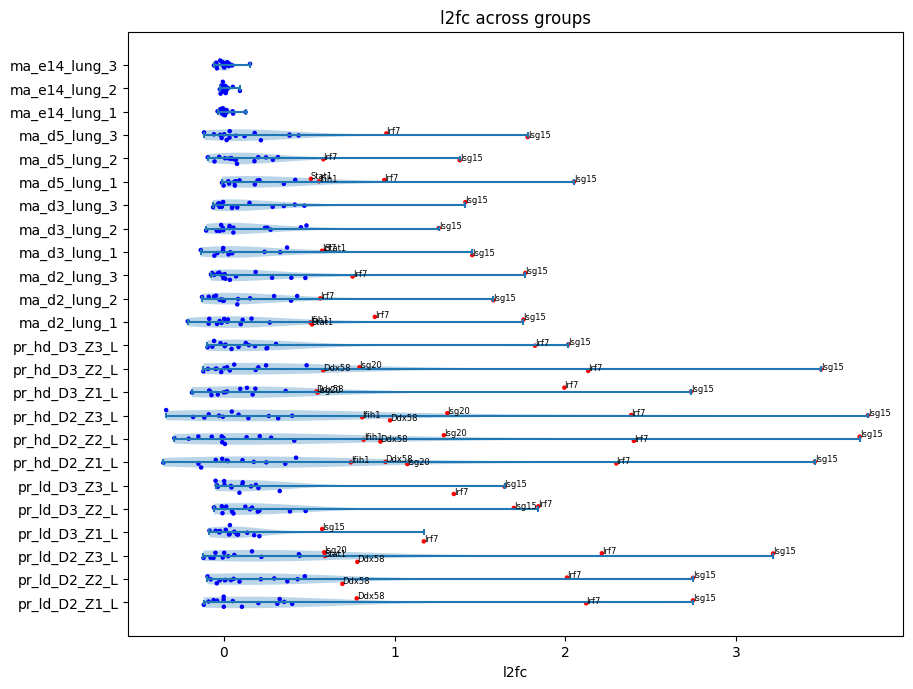

In [34]:
l2fc_tab = differential_test(mdata, genes, 'orig.ident', control=control_dict, sort_groups=False)[-1]
DEviolin(l2fc_tab, figsize=[10,8], dpi=100, cutoff=0.5, show=True)

## Endothelial cell activation (too few genes)

In [239]:
genes = ['SELP', 'SELE', 'VCAM1', 'ICAM1', 'THBD', 'HSPG2', 'SERPINE1', 'IL6', 'IL8', 'CCL2', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5']
genes = [x for x in pd.unique(list(specify_genes(genes, 'human', 'mouse'))) if x in mdata.var_names] + ['H2-Eb1']
sc.tl.score_genes(mdata, genes, score_name='ECA_score')

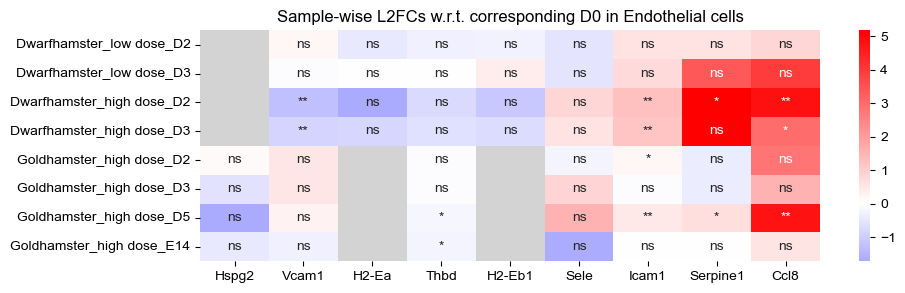

In [241]:
fig, ax = pl.subplots(figsize=[10,3], dpi=100)
ax = plot_differential_test(mdata, genes, 'organism_dosage_time', cluster='col',
                       control=control_dict_odt, replicate_key='orig.ident', 
                       show=False)
pl.title('Sample-wise L2FCs w.r.t. corresponding D0 in Endothelial cells')
# pl.savefig(figure_path / f'Hallmarks_l2fcs.pdf', bbox_inches='tight')
pl.show()

# Diffusion Analysis

## Prepare data

In [4]:
# remove doublet and lymphatic clusters, not connected to main cluster in KNN graph
doublet_clusters = ['9', '10', '12', '15', '14']
lymphatic_clusters = ['11']
sdata = mdata[~np.isin(mdata.obs.louvain_scVI, doublet_clusters+lymphatic_clusters)].copy()
sc.tl.diffmap(sdata, neighbors_key='neighbors_scVI')

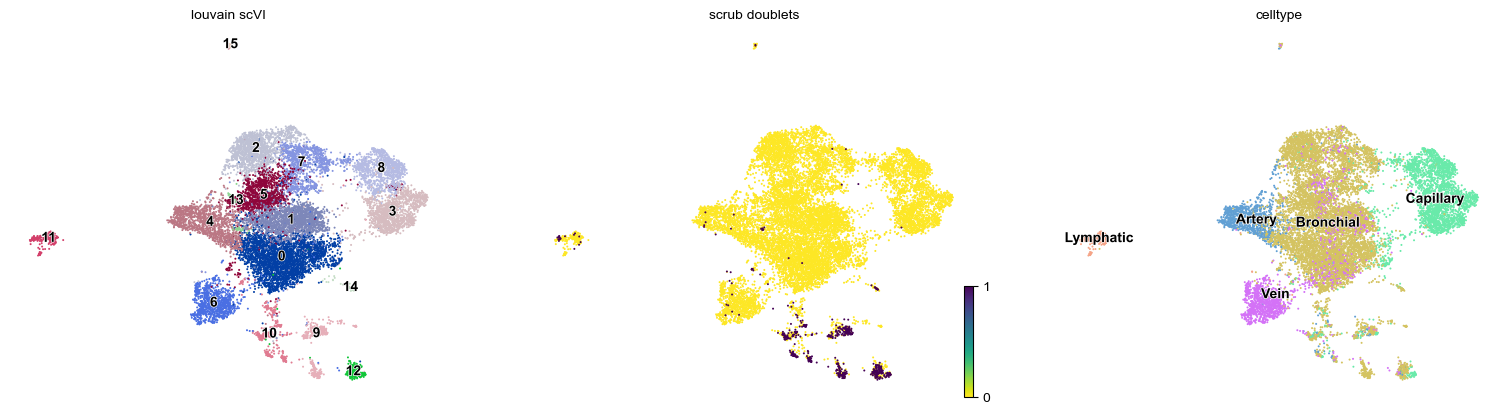

In [5]:
# Review cells thrown out
scv.pl.scatter(mdata, basis='umap_scVI', dpi=100, color=['louvain_scVI','scrub_doublets', 'celltype'], legend_loc='on data')

## Global Visualizations

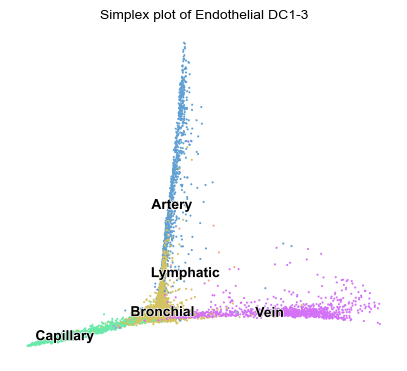

In [91]:
def uniform_normalization(x, axis=0):
    return (x - np.min(x, axis=axis)) / (np.max(x, axis=axis) - np.min(x, axis=axis))

from scipy.stats import zscore
from scipy.special import softmax
U = sdata.obsm['X_diffmap'][:,1:4].copy()
U[:,1] = -U[:,1]  # correction
U[:,2] = -U[:,2]  # correction
X = uniform_normalization(U, axis=0)
Y = softmax(X, axis=1)

Z = []
for a,b,c in Y:
    x = 0.5 * (2*b+c)/(a+b+c)
    y = np.sqrt(3)/2 * c/(a+b+c)
    Z.append([x,y])
Z = np.array(Z)
sdata.obsm['X_simplex'] = Z

h = 1/2 * (3**(0.5))
scv.pl.scatter(sdata, basis='simplex', color='celltype', title='Simplex plot of Endothelial DC1-3', figsize=[5, 5*h])

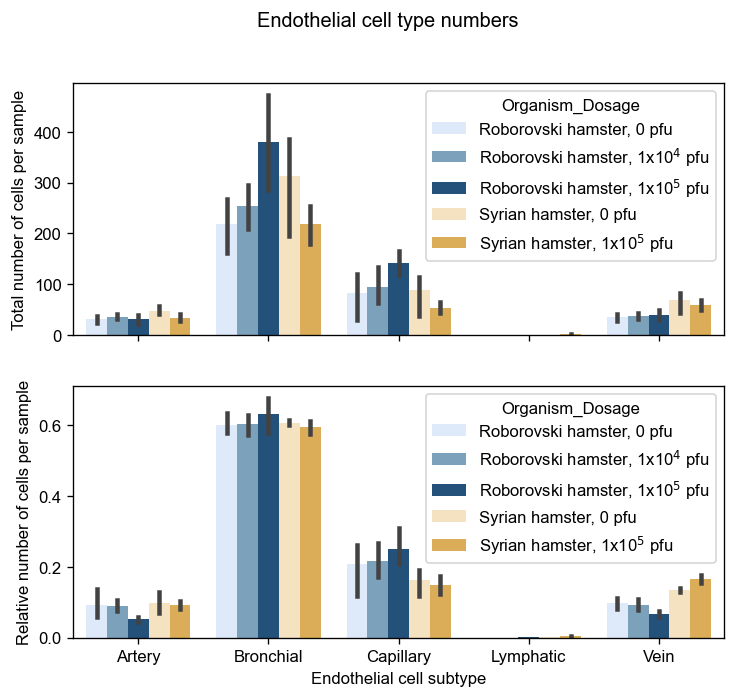

In [320]:
# Cell numbers stay the same
# compute cell frequencies
sdf = sdata.obs.value_counts(['orig.ident', 'celltype', 'Organism_Dosage'], 
                             sort=False, normalize=False)
cells_per_sample = sdf.reset_index().groupby(['orig.ident']).sum()
fractions = (sdf.reset_index(level=1) / cells_per_sample)[0]
adf = sdf.to_frame('total').reset_index()
adf['freq'] = fractions.values

fig, axs = pl.subplots(2,1, figsize=[7, 3*2], dpi=120, sharex=True)
kwargs = dict(x='celltype', hue='Organism_Dosage', dodge=True, palette=Organism_Dosage_colors)

ax = axs[0]
sns.barplot(data=adf, y='total', ax=ax, **kwargs)
ax.set_ylabel('Total number of cells per sample')
ax.set_xlabel('')

ax = axs[1]
sns.barplot(data=adf, y='freq', ax=ax, **kwargs)
ax.set_ylabel('Relative number of cells per sample')
ax.set_xlabel('Endothelial cell subtype')

pl.suptitle('Endothelial cell type numbers')

pl.savefig(figure_path / f'Endothelial_celltype_numbers.pdf', bbox_inches="tight")
pl.show()

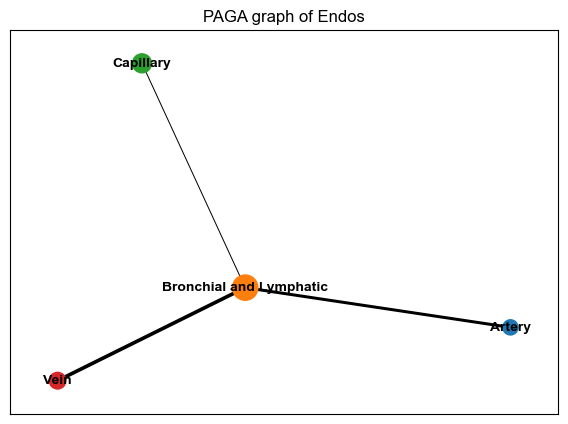

In [8]:
# PAGA plot
sdata.obs['celltype_2'] = sdata.obs['celltype'].astype(str)
sdata.obs['celltype_2'][sdata.obs['celltype_2']=='Lymphatic'] = 'Bronchial and Lymphatic'
sdata.obs['celltype_2'][sdata.obs['celltype_2']=='Bronchial'] = 'Bronchial and Lymphatic'
sc.tl.paga(sdata, 'celltype_2', neighbors_key='neighbors_scVI')
sc.pl.paga(sdata, threshold=0.09, show=False, title='PAGA graph of Endos')
pl.savefig(figure_path / f'Endos_PAGA.pdf', bbox_inches="tight")
pl.show()

## Explanation / Latent ANOVA

In [6]:
# define features for ANOVA to test
columns = mdata.obs.columns
c_progeny = list(columns[columns.str.contains('progeny')])
get_ribo_percentage(sdata, 'mouse')
# Exclude hallmarks that always pop up in any analysis and are not interesting
exclude_hallmarks = ['HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_ADIPOGENESIS',
                     'HALLMARK_KRAS_SIGNALING_DN', 'HALLMARK_KRAS_SIGNALING_UP',
                     'HALLMARK_UV_RESPONSE_DN', 'HALLMARK_UV_RESPONSE_UP'
                     ]
c_hallmark = [c for c in columns[columns.str.contains('HALLMARK')] if c not in exclude_hallmarks]
c_sample = ['time', 'organism', 'celltype', 'dosage']  # sample-wise keys
c_percell = ['SCoV2_detected', 'SCoV2_load', 'percent_ribo', 'kegg_rigI_score']  # other keys per cell

keys = c_progeny + c_hallmark + c_sample + c_percell

# display style
rename_dict={
            'kegg_rigI_score': 'RIG-I pathway (KEGG)',
            'SCoV2_detected': 'SARS-CoV-2 found in cell',
            'percent_ribo': 'Percent ribosomal counts',
            'SCoV2_load': 'SARS-CoV-2 quantity in cell',
            'time': 'Time after infection',
            'organism': 'Organism (Roborovski / Syrian)',
            'celltype': 'Endothelial subtype',
            'dosage': 'Viral dosage given',
            **{key: key.replace('_progeny', ' signaling (progeny)') for key in c_progeny},
            **{key: key.replace('HALLMARK_', '').capitalize().replace('_', ' ')+' (MSigDB)' for key in c_hallmark}
            }

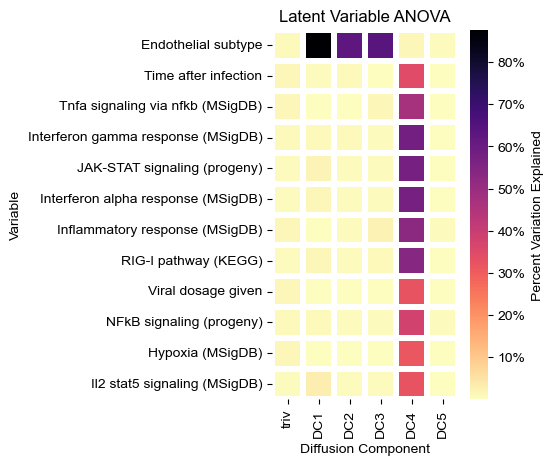

In [7]:
# diffmap
mat = getExplanatoryPCs(sdata, keys, use_rep='X_diffmap')
mat = mat.rename(index=rename_dict)
mat = mat[mat.max(1) > 30]  # keep keys that explain at least XX% of the variance
mat = cluster_matrix(pd.DataFrame(mat.values.astype(float), index=mat.index, columns=mat.columns), how='row')
plotExplanatoryPCs_heatmap(mat, N_components=6, show=False)
pl.savefig(figure_path / 'Fig5B_Endo_diffmap_heatmap.pdf', bbox_inches='tight')
pl.show()

In [8]:
# Export for supplementary table
mat.to_csv(table_path / f'Fig5B_source.csv')

## Plots along DC4

In [6]:
dc_i = 4
sdata.obs[f'DC{dc_i}'] = sdata.obsm['X_diffmap'][:,dc_i]
sdata.obs['replicate'] = [x[2] for x in sdata.obs.hamster]

# Binarize DC4
p_off = 0
range_percs = [p_off, 100 - p_off]
n_bins=50

X = sdata.obs[f'DC{dc_i}']
xmin = np.percentile(X, range_percs[0])
xmax = np.percentile(X, range_percs[1])
numbers, bins = np.histogram(X, range=[xmin, xmax], bins=n_bins)

In [43]:
# linearly correlate DC4 with each gene
df_corr = lin_corr_adata(sdata, sdata.obsm['X_diffmap'][:,dc_i], sdata.var_names, method='spearman')

100%|██████████| 12855/12855 [00:19<00:00, 645.06it/s]


## Densities

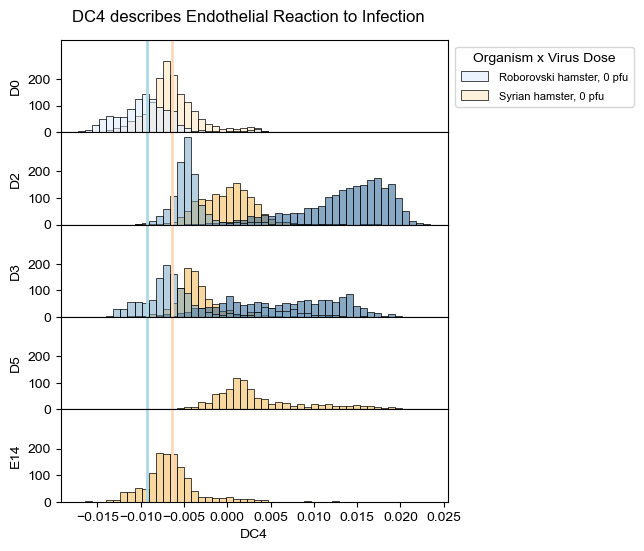

In [51]:
fig, axs = pl.subplots(5, 1, sharex=True, figsize=[5,6], dpi=100, sharey=True)
m_dwarf = np.mean(sdata.obs.DC4[(sdata.obs.time=='D0')&(sdata.obs.Organism=='Roborovski hamster')])
m_gold = np.mean(sdata.obs.DC4[(sdata.obs.time=='D0')&(sdata.obs.Organism=='Syrian hamster')])
for i, t in enumerate(pd.unique(sdata.obs.time)):
    ax = axs[i]
    add_legend = i==0
    sns.histplot(data=sdata.obs[sdata.obs.time==t], x='DC4', hue='Organism_Dosage', 
                 ax=ax, bins=bins, legend=add_legend, linewidth=0.5,
                 palette=Organism_Dosage_colors
                )
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    ax.set_yticks([0, 100, 200])
    ax.set_ylabel(f'{t}')
    ax.axvline(m_gold, linewidth=2, color='peachpuff')
    ax.axvline(m_dwarf, linewidth=2, color='lightblue')
    if add_legend: 
        sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
        pl.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
        pl.setp(ax.get_legend().get_title(), fontsize='10', text='Organism x Virus Dose') # for legend title

pl.subplots_adjust(wspace=0, hspace=0)
#axs[-1].set_xticks([(m_dwarf+m_gold)/2])
#axs[-1].set_xticklabels(['Ground States\n(Mean DC4 before infection)'])
pl.suptitle('DC4 describes Endothelial Reaction to Infection', y=0.93)

pl.savefig(figure_path / 'Fig5C_Endo_DC4_dynamics_histplot.pdf', bbox_inches='tight', dpi=300)
pl.show()

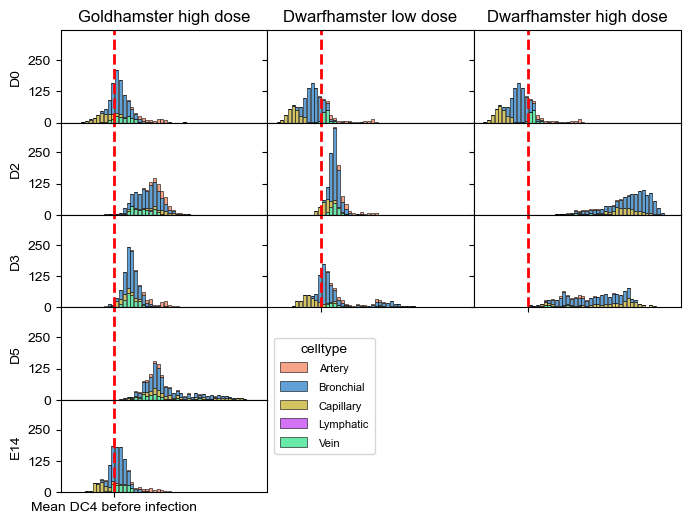

In [32]:
x_key = 'organism_dosage'
y_key = 'time'

fig, axss = pl.subplots(5, 3, sharex=True, figsize=[8,6], dpi=100, sharey=True)
m = np.mean(sdata.obs.DC4[sdata.obs.time=='D0'])
for i, t in enumerate(pd.unique(sdata.obs[y_key])):
    axs = axss[i]
    for j, (o, d) in enumerate(zip(['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose'])):
        ax = axs[j]
        add_legend = i==4 and o=='Goldhamster'
        d_ = 'no dose' if t == 'D0' else d
        if np.isin(t, ['D5', 'E14']) and o=='Dwarfhamster':
            ax.remove()
            continue
        sns.histplot(data=sdata.obs[(sdata.obs.time==t) & (sdata.obs['organism']==o) & (sdata.obs['dosage']==d_)], 
                     x='DC4', hue='celltype', 
                    ax=ax, bins=bins, legend=add_legend, linewidth=0.4,
                    palette=endo_colors, multiple='stack', shrink=0.8, alpha=1, stat='density'
                    )
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([0, 125, 250])
        ax.set_ylabel(f'{t}')
        ax.axvline(m, linewidth=2, color='red', ls='--')
        if add_legend: 
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.75))
            pl.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
            pl.setp(ax.get_legend().get_title(), fontsize='10', text='celltype') # for legend title
        if i==0:
            ax.set_title(f'{o} {d}')
        if i==4 and o=='Goldhamster':
            ax.set_xticks([m])
            ax.set_xticklabels(['Mean DC4 before infection'])
pl.subplots_adjust(wspace=0, hspace=0)
pl.savefig(figure_path / 'FigS5X_DC4_endo_subtype_histograms.pdf', bbox_inches='tight')
pl.show()

In [30]:
# Export for supplementary table
sdata.obs[['DC4', 'time', 'Organism_Dosage']].to_csv(table_path / f'Fig5C_source.csv')

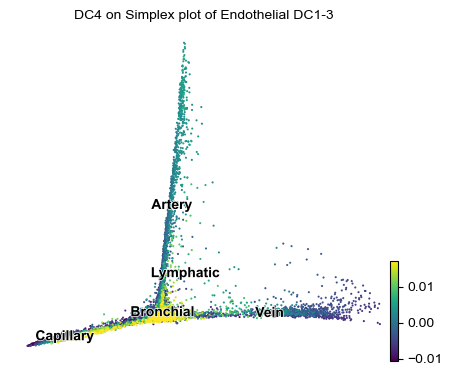

In [92]:
ax = scv.pl.scatter(sdata, basis='simplex', color='DC4', 
               title='', cmap='viridis',
               figsize=[5, 5*1/2 * (3**(0.5))], perc=[5,95], show=False)
scv.pl.scatter(sdata, basis='simplex', color='celltype', 
               title='DC4 on Simplex plot of Endothelial DC1-3', ax=ax, alpha=0, s=0, legend_loc='on data',
               figsize=[5, 5*1/2 * (3**(0.5))], perc=[5,95], show=False)
pl.savefig(figure_path / 'FigS5X_Endo_DC4_on_simplex.svg', bbox_inches='tight', dpi=300)
pl.show()

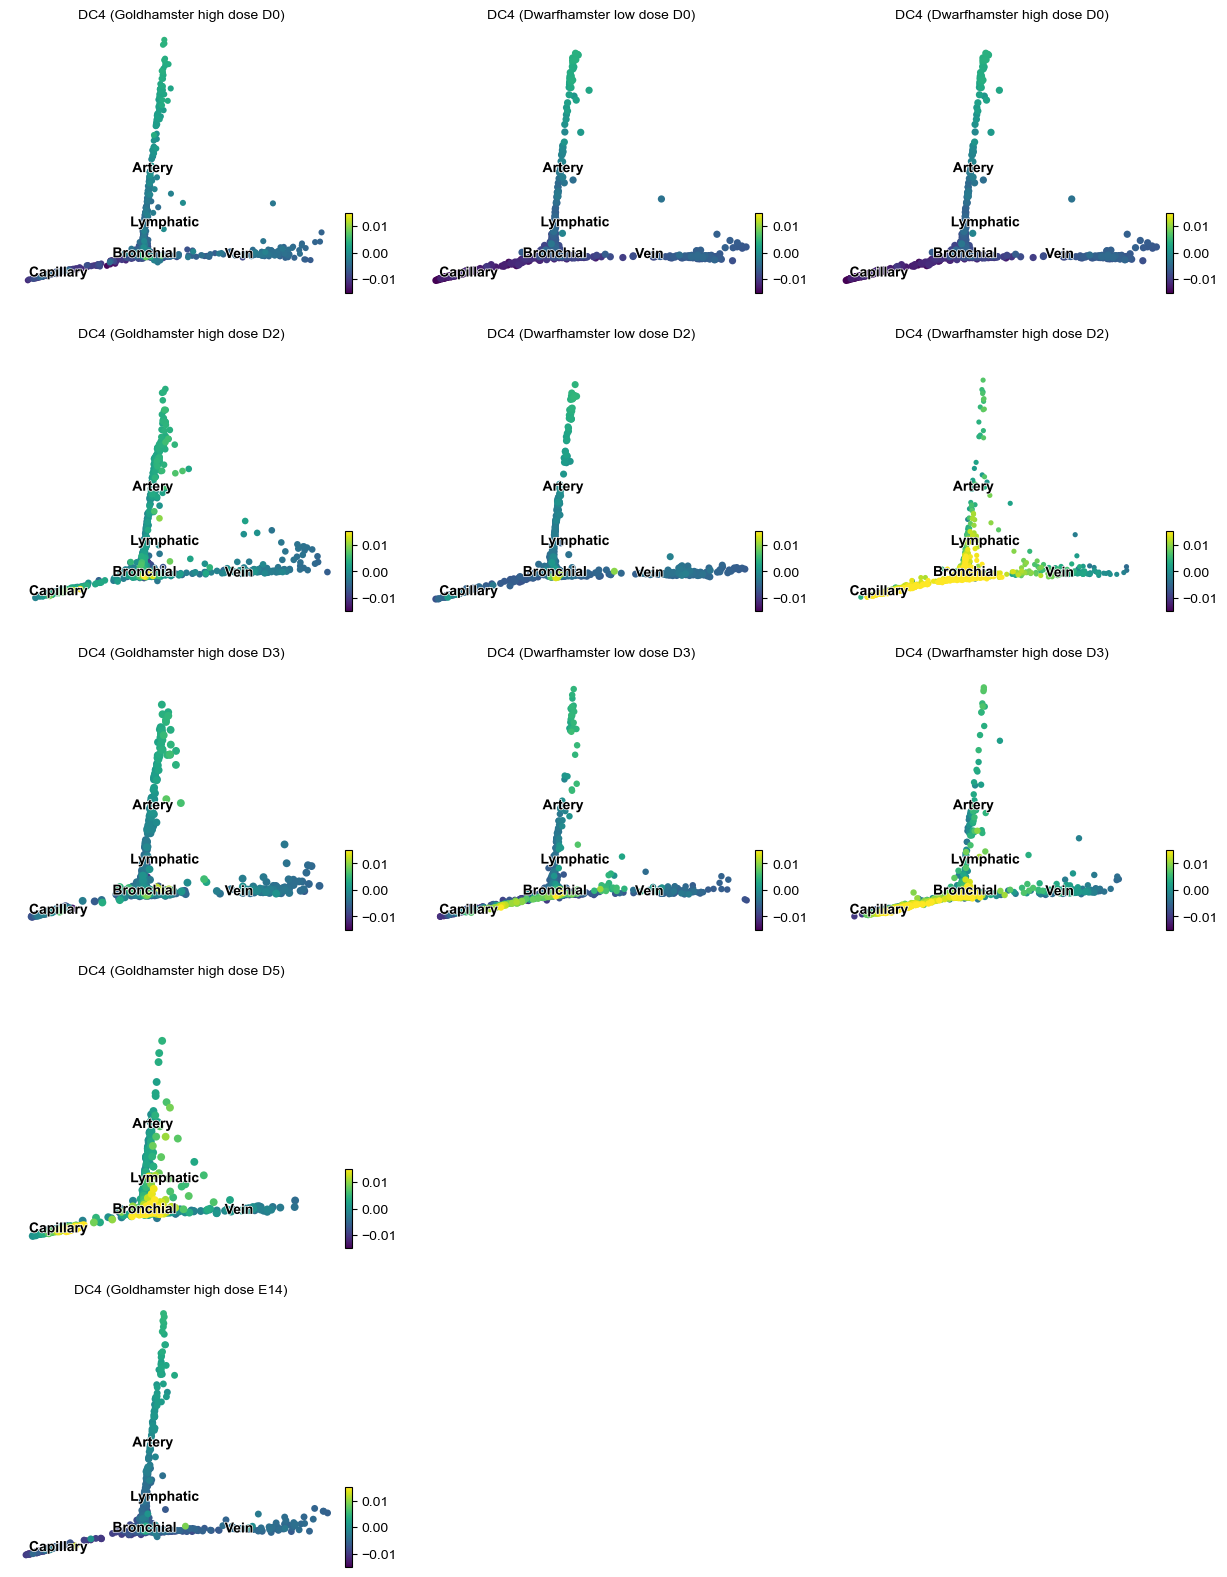

In [33]:
kwargs = dict(basis='simplex', color='DC4', cmap='viridis', show=False, vmin=-0.015, vmax=0.015)

fig, axss = pl.subplots(5,3, figsize=[15,20], dpi=100)
for axs, t in zip(axss, pd.unique(sdata.obs.time)):
    for ax, (o, d) in zip(axs, [('Goldhamster', 'high dose'), ('Dwarfhamster', 'low dose'), ('Dwarfhamster', 'high dose')]):
        if np.isin(t, ['D5', 'E14']) and o=='Dwarfhamster':
            ax.remove()
            continue
        mask = (sdata.obs.time==t) & (sdata.obs['organism']==o) & (sdata.obs['dosage'].isin([d, 'no dose']))
        scv.pl.scatter(sdata[mask], title=f'{o} {d}', ax=ax, **kwargs)
        scv.pl.scatter(sdata, basis='simplex', color='celltype', 
                title=f'DC4 ({o} {d} {t})', ax=ax, alpha=0, s=0, legend_loc='on data',
                figsize=[5, 5*1/2 * (3**(0.5))], perc=[5,95], show=False)

## Genes

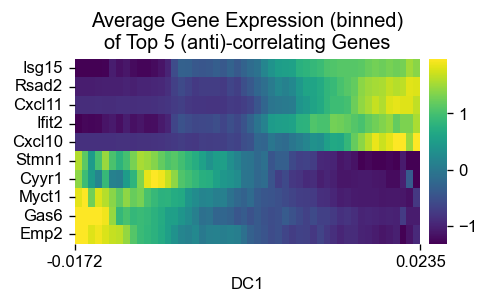

In [52]:
N = 5  # number of top and bottom correlating genes to plot
top = list(df_corr.index[:N])
bot = list(df_corr.index[-N:])
genes = top + bot

# Get binned mean expression
binned_mean_exp = pd.DataFrame(index=genes, columns=np.arange(n_bins))
for i in range(n_bins):
    Y = sdata[(X>bins[i]) & (X<bins[i+1]), genes].X.A
    binned_mean_exp[i] = np.mean(Y, axis=0)

# Normalize
from scipy.stats import zscore
T_raw = binned_mean_exp.T.sort_index(ascending=True).T
T = zscore(T_raw, axis=1)

# Plot
fig, axs = pl.subplots(1, 2, figsize=[4,2], dpi=120, gridspec_kw={'width_ratios': [10, .5], 'wspace': 0.05})
sns.heatmap(T, cmap='viridis', robust=True, ax=axs[0], cbar_ax=axs[1], cbar_kws={'orientation': "vertical"})
axs[0].set_xticks([0, n_bins])
axs[0].set_xticklabels(np.round([xmin, xmax],4))
axs[0].set_xlabel('DC1')
axs[0].set_title(f'Average Gene Expression (binned)\nof Top {N} (anti)-correlating Genes')
pl.savefig(figure_path / f'Fig5D_Endo_DC4_corr_genes_binned.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [35]:
infl_genes=['CXCL10', 'CCL2', 'CCL5', 'FPR1', 'CCL20', 'IL1A', 'IL8', 'CCL7', 'CCL22', 'CXCL11', 'CCR7', 'EDN1', 'CD40', 'CXCL9', 'IL6', 'IL1B', 'TLR2', 'IL1R1', 'CD69', 'ICAM1', 'CCRL2', 'AQP9', 'EREG', 'C3AR1', 'GNA15', 'CMKLR1', 'PTGER4', 'LIF', 'IL15', 'NAMPT', 'OPRK1', 'ITGB8', 'PTAFR', 'ADM', 'PLAUR', 'NFKB1', 'INHBA', 'OSM', 'TNFSF10', 'TNFSF15', 'IFNGR2', 'EMR1', 'IL12B', 'CSF1', 'CXCL6', 'TNFRSF9', 'LYN', 'ACVR2A', 'LDLR', 'BDKRB1', 'HRH1', 'F3', 'BST2', 'PTGIR', 'CD55', 'CALCRL', 'CSF3', 'GPR132', 'IL4R', 'NLRP3', 'IL15RA', 'ADORA2B', 'GCH1', 'OLR1', 'PTGER2', 'CSF3R', 'MYC', 'RELA', 'TNFAIP6', 'IL7R', 'IL18', 'GABBR1', 'CD82', 'TNFSF9', 'NMUR1', 'IL2RB', 'TLR1', 'LPAR1', 'IRAK2', 'RIPK2', 'MMP14', 'P2RX7', 'SLC11A2', 'SELL', 'P2RY2', 'ABCA1', 'FFAR2', 'PROK2', 'GNAI3', 'TACR1', 'SLC7A1', 'CDKN1A', 'CYBB', 'TIMP1', 'HBEGF', 'SCARF1', 'EBI3', 'NFKBIA', 'SRI', 'SLC7A2', 'CCL17', 'TLR3', 'APLNR', 'OSMR', 'IL10RA', 'PSEN1', 'GPR183', 'ATP2B1', 'TNFRSF1B', 'BEST1', 'GPC3', 'SCN1B', 'ACVR1B', 'HPN', 'SEMA4D', 'KLF6', 'CD48', 'CXCR6', 'SLC1A2', 'GP1BA', 'TAPBP', 'RGS16', 'SLAMF1', 'LCK', 'HIF1A', 'AHR', 'NMI', 'RHOG', 'TPBG', 'NPFFR2', 'IFNAR1', 'ICOSLG', 'RASGRP1', 'IFITM1', 'KCNJ2', 'LY6E', 'IL18R1', 'IL10', 'KCNA3', 'HAS2', 'DCBLD2', 'LAMP3', 'VIP', 'CD70', 'RGS1', 'SLC31A1', 'ADRM1', 'KCNMB2', 'SERPINE1', 'MXD1', 'AXL', 'MEFV', 'PVR', 'CCL24', 'PDE4B', 'LCP2', 'PDPN', 'IRF7', 'MET', 'ATP2A2', 'SLC31A2', 'FZD5', 'ITGA5', 'SGMS2', 'MARCO', 'CD14', 'EIF2AK2', 'ROS1', 'ATP2C1', 'NDP', 'BTG2', 'MSR1', 'PTPRE', 'RNF144B', 'PCDH7', 'SPHK1', 'IL18RAP', 'RTP4', 'RAF1', 'CHST2', 'ITGB3', 'KIF1B', 'SELE', 'NOD2', 'C5AR1', 'EMP3', 'CLEC5A', 'TACR3', 'SLC4A4', 'MEP1A', 'SELS', 'LTA', 'PIK3R5', 'STAB1', 'IRF1', 'ICAM4', 'P2RX4', 'ABI1', 'CX3CL1', 'SLC28A2']
infl_genes = specify_genes(infl_genes, 'human', 'mouse')

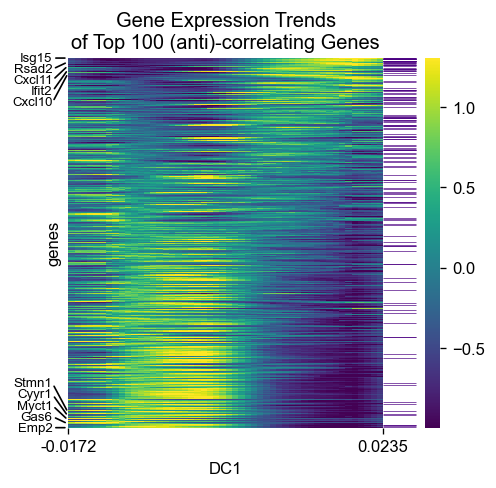

In [54]:
M = 100  # number of genes to use for background
K = 10  # kernel size
x_offset = 0.05  # offset for x-axis labels in fraction
y_spacing = 3  # spacing between y-axis labels in multiples of height increments

background = df_corr.index#list(df_4.index[:M]) + list(df_4.index[-M:])
binned_mean_exp = pd.DataFrame(index=background, columns=np.arange(n_bins))
for i in range(n_bins):
    Y = sdata[(X>bins[i]) & (X<bins[i+1]), background].X.A
    binned_mean_exp[i] = np.mean(Y, axis=0)

from scipy.stats import zscore
T_raw = binned_mean_exp.T.sort_index(ascending=True).T
T = zscore(T_raw, axis=1)
for gene in T.index:
    T.loc[gene] = np.convolve(T.loc[gene], np.ones(K)/K, 'same')

fig, axs = pl.subplots(1, 2, figsize=[4,4], dpi=120, gridspec_kw={'width_ratios': [10, .5], 'wspace': 0.25})
ax = axs[0]
sns.heatmap(T, cmap='viridis', robust=True, ax=ax, cbar_ax=axs[1], cbar_kws={'orientation': "vertical"})
axs[0].set_xticks([0, n_bins])
axs[0].set_xticklabels(np.round([xmin, xmax],4))
ax.set_xlabel('DC1')
ax.set_yticks([ik for ik, k in enumerate(T.index) if k in infl_genes])
ax.yaxis.tick_right()
ax.tick_params('y', length=20, width=.4, which='major', color='indigo')
for i in range(N):
    ax.annotate(bot[N-1-i], xy=(0, i/M), xytext=(-x_offset,y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8)
    ax.annotate('', xy=(0, i/M), xytext=(-x_offset,y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8, arrowprops=dict(arrowstyle="-"))
    ax.annotate(top[i], xy=(0, 1-i/M), xytext=(-x_offset,1-y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8)
    ax.annotate('', xy=(0, 1-i/M), xytext=(-x_offset,1-y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8, arrowprops=dict(arrowstyle="-"))
ax.set_title(f'Gene Expression Trends\nof Top {M} (anti)-correlating Genes')
pl.savefig(figure_path / f'FigS5X_Endo_DC4_corr_all_genes_binned.png', bbox_inches='tight', dpi=300)
pl.show()

In [37]:
# Export unnormalized data for supplementary table
T_raw.columns.name = 'DC4_bin'
T_raw.to_csv(table_path / f'Fig5D_and_S5C_source.csv')

## Scores along DC

In [5]:
i=4
sdata.obs[f'DC{i}'] = sdata.obsm['X_diffmap'][:,i]
# get hallmark score columns
c = sdata.obs.columns
keys = list(c[c.str.startswith('HALLMARK_')])
# rank by correlation with DC
LCA = lin_corr_adata(sdata, sdata.obsm['X_diffmap'][:,i], keys, method='spearman')
LCA = LCA[(LCA.spearman_r.abs() > 0.45) & (LCA.spearman_p < 0.05)]
top_keys = list(LCA.index)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 465.30it/s]


In [6]:
# smooth lines
dmin = np.min(sdata.obsm['X_diffmap'][:, i])
dmax = np.max(sdata.obsm['X_diffmap'][:, i])
eval_x = np.linspace(dmin, dmax, 30)
results = []
for key in tqdm(top_keys):
    for organism, dosage in zip(['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose']):
        # select organism and dosage, always include no dose of corresponding organism
        mask = (sdata.obs.organism == organism) & ((sdata.obs.dosage == dosage) | (sdata.obs.dosage == 'no dose'))
        smoothed, bottom, top = lowess_with_confidence_bounds(
            sdata.obs[f'DC{i}'][mask], 
            sdata.obs[key][mask], 
            eval_x, N=1, lowess_kw={"frac": 2/3}, conf_interval=0.99)
        sdf = pd.DataFrame([smoothed, bottom, top], index=['smoothed', 'bottom', 'top']).T
        sdf['organism'] = f'{organism}_{dosage}'
        sdf['key'] = key
        sdf['x'] = eval_x
        sdf['Nx'] = np.arange(len(eval_x))
        # count number of cells in each bin for later filtering
        bin_counts, bins_ = np.histogram(sdata.obs[f'DC{i}'][mask], bins=30, range=(dmin, dmax))
        sdf['bin_counts'] = bin_counts
        results.append(sdf)
res = pd.concat(results).reset_index()     

100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


In [7]:
# strict sort order for plotting
sdata.obs.Organism_Dosage_ = sdata.obs.Organism_Dosage.astype(str)
sdata.obs.Organism_Dosage_.replace({
'Roborovski hamster, 0 pfu': 2,
'Roborovski hamster, $1\\times10^4$ pfu': 3,
'Roborovski hamster, $1\\times10^5$ pfu': 4,
'Syrian hamster, 0 pfu': 0,
'Syrian hamster, $1\\times10^5$ pfu': 1
}, inplace=True)
index = sdata.obs.Organism_Dosage_.astype(int).sort_values().index

In [15]:
# Prevents a bug, do not remove!
fig, ax = pl.subplots(1,1, figsize=[6,4], dpi=120)
ax = scv.pl.scatter(sdata, basis='diffmap', color='Organism_Dosage', 
                    components='1,3', legend_loc=False, show=False, 
                    title='', ax=ax,
                    palette=Organism_Dosage_colors, s=20,
                    )
pl.close()

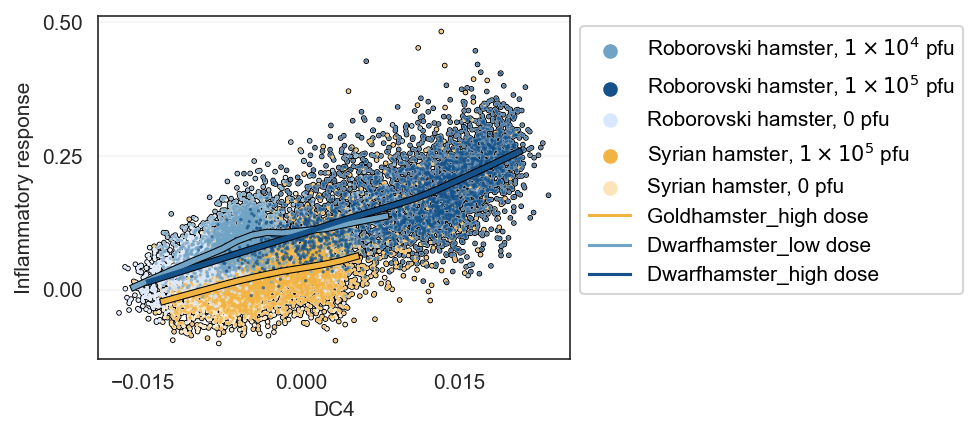

In [16]:
# Plot: split by pathway
key = 'HALLMARK_INFLAMMATORY_RESPONSE'
with sns.axes_style("white"):
    fig, ax = pl.subplots(1, 1, figsize=[4, 3], dpi=150, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

key_name = key.replace('HALLMARK_', '').capitalize().replace('_', ' ')
sres = res[res.key==key]
data = sdata.obs.copy().sample(frac=1)  # shuffle
ax = scv.pl.scatter(sdata[index], x='DC4', y=key, color='Organism_Dosage', 
                    legend_loc=False, show=False, 
                    title='', ax=ax, alpha=0.7, add_outline=True,
                    palette=Organism_Dosage_colors, 
                    s=10,
                    )
# generate low cell count mask, remove points will less than X cells in bin
threshold = sres.groupby('organism').sum()['bin_counts'] * 0.01
cellmask = [(sres.organism==organism) & (sres.bin_counts > threshold[organism]) for organism in sres.organism.unique()]
cellmask = np.any(cellmask, axis=0)
# add outline
sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, legend=False,
                palette={k: 'black' for k in organism_dosage_colors.keys()}, linewidth=2.5 + 1)
# add line
sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, 
                palette=organism_dosage_colors, linewidth=2.5, legend=True)
ax.set_ylabel(key_name)#.replace(' ', '\n', 1))
# ax.set_xticklabels([])
ax.set_xlabel(f'DC{i}')
ax.grid(True, axis='y', alpha=0.2)
pl.tight_layout()
# for text in ax.legend_.get_texts(): text.set_text(sanitize_name(text.get_text()))  # not working and I do not know why
pl.legend(bbox_to_anchor=(1,1))
#ax.set_title(f'ENDOS\nSmoothed scores of top GSEA results\non DC{i} correlated genes')
pl.savefig(figure_path / f'Fig5X_Endo_DC{i}_dynamics_{key_name}_grouped.pdf', bbox_inches='tight', dpi=300)
pl.savefig(figure_path / f'Fig5X_Endo_DC{i}_dynamics_{key_name}_grouped.png', bbox_inches='tight', dpi=300)
pl.show()


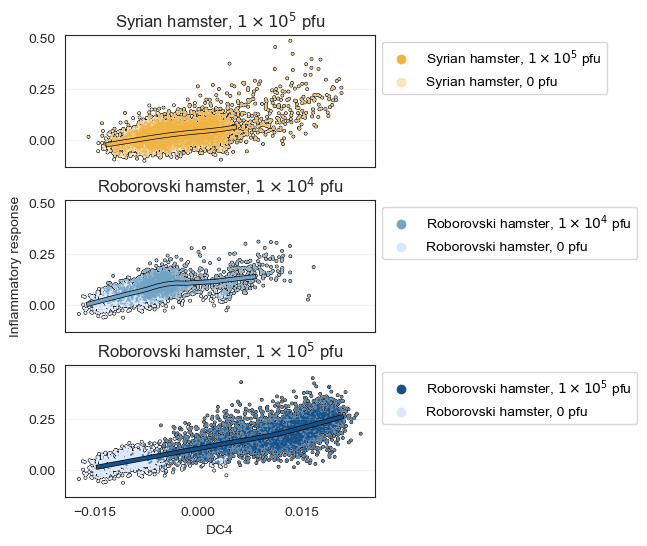

In [19]:
# Plot: split by "line", color by time, Inf Resp only
with sns.axes_style("white"):
    fig, axs = pl.subplots(3, 1, figsize=[4, 6], dpi=100, sharex=True, sharey=True, gridspec_kw={'hspace': 0.25})

organism_dosage_time_colors = config['organism_dosage_time_colors']
for ax, organism in zip(axs, ['Goldhamster_high dose', 'Dwarfhamster_low dose', 'Dwarfhamster_high dose']):
    o, d = organism.split('_')
    key = 'HALLMARK_INFLAMMATORY_RESPONSE'
    sres = res[(res.organism==organism) & (res.key==key)]
    # generate low cell count mask, remove points will less than X cells in bin
    threshold = sres.sum()['bin_counts'] * 0.01
    cellmask = (sres.bin_counts > threshold)
    key_name = key.replace('HALLMARK_', '').capitalize().replace('_', ' ')
    
    not_dosage = 'low dose' if d=='high dose' else 'high dose'
    palette={k.split('_')[-1]: c for k, c in organism_dosage_time_colors.items() if o in k and not_dosage not in k}
    data = sdata.obs[(sdata.obs.organism==o) & (sdata.obs.dosage.isin([d, 'no dose']))].copy().sample(frac=1)  # shuffle
    data.time.cat.remove_unused_categories(inplace=True)
    scv.pl.scatter(sdata[(sdata.obs_names.isin(index)) & (sdata.obs.organism==o) & (sdata.obs.dosage.isin([d, 'no dose']))], 
                   x='DC4', y=key, color='Organism_Dosage', 
                   legend_loc=False, show=False, 
                   title='', ax=ax, alpha=0.7, add_outline=True,
                   palette=Organism_Dosage_colors, s=10,
                   )
    
    # add outline
    sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, legend=False,
                 palette={k: 'black' for k in organism_dosage_colors.keys()}, linewidth=2.5 + 1)
    # add line
    sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, 
                 palette=organism_dosage_colors, linewidth=2.5, legend=False)
    ax.set_title(sanitize_name(organism))
    ax.legend(bbox_to_anchor=(1,1))
    if ax != axs[-1]: ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True, axis='y', alpha=0.2)
axs[1].set_ylabel(key_name)
#axs[0].set_xticklabels([])
axs[-1].set_xlabel(f'DC{i}')
pl.savefig(figure_path / f'FigS5X_Endo_DC{i}_dynamics_{key_name}_grouped.pdf', bbox_inches='tight', dpi=300)
pl.savefig(figure_path / f'FigS5X_Endo_DC{i}_dynamics_{key_name}_grouped.png', bbox_inches='tight', dpi=300)
pl.show()


## GSEA

In [ ]:
# GSEA
df = df_corr.copy()

df = df[sdata.var.loc[df.index, 'means'] > np.median(sdata.var.loc[df.index, 'means'])]
df = df[~df.spearman_r.isna()].sort_values('spearman_r', ascending=False)
df.index = specify_genes(df.index, 'mouse', 'human')  # use human gene sets
ranked_genes= df[['spearman_r']]

# run GSEA
pre_res = gp.prerank(rnk=ranked_genes,
                        gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020'],
                        threads=8,
                        min_size=15,  # gene sets with less than that many genes in data are ignored
                        max_size=1000,  # gene sets with more than that many genes in data are ignored
                        permutation_num=1000,
                        outdir=None, # don't write to disk
                        seed=42,
                        verbose=False
                    )
res = extract_gsea_results(pre_res, ["KEGG_2021_Human", 'MSigDB_Hallmark_2020'])
sig_res = res[res['FWER p-val']<0.05]


2023-06-03 15:12:22,828 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [ ]:
# Export GSEA results
res.to_csv(table_path / 'Fig5E_and_S5A_source.csv')

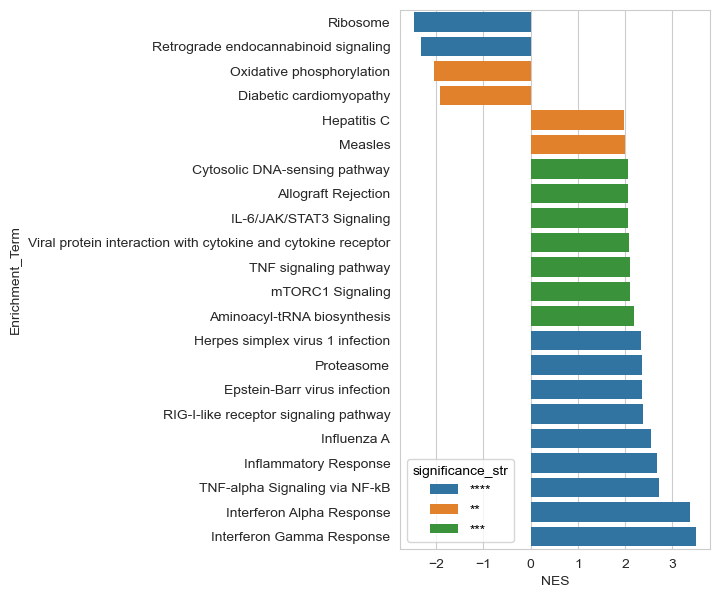

In [ ]:
with sns.axes_style("whitegrid"):
    fig, ax = pl.subplots(1, 1, figsize=[4, 7], dpi=100)
sns.barplot(data=sig_res, 
            y='Enrichment_Term', x='NES', 
            hue='significance_str', dodge=False)
pl.savefig(figure_path / 'FigS5X_Endo_DC4_dynamics_GSEA.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [ ]:
# overlap of lead genes across gene sets
# might use this to cluster gene sets
from sklearn.metrics import jaccard_score
sig_res
J = pd.DataFrame(index=sig_res.Enrichment_Term, columns=sig_res.Enrichment_Term, dtype=float)
for index1 in sig_res.index:
    genes1 = set(sig_res.loc[index1, 'Lead_genes'].split(';'))
    for index2 in sig_res.index:
        genes2 = set(sig_res.loc[index2, 'Lead_genes'].split(';'))
        jac = len(genes1.intersection(genes2)) / len(genes1.union(genes2))
        J.loc[sig_res.loc[index1, 'Enrichment_Term'], sig_res.loc[index2, 'Enrichment_Term']] = jac
J = cluster_matrix(J, how='both')

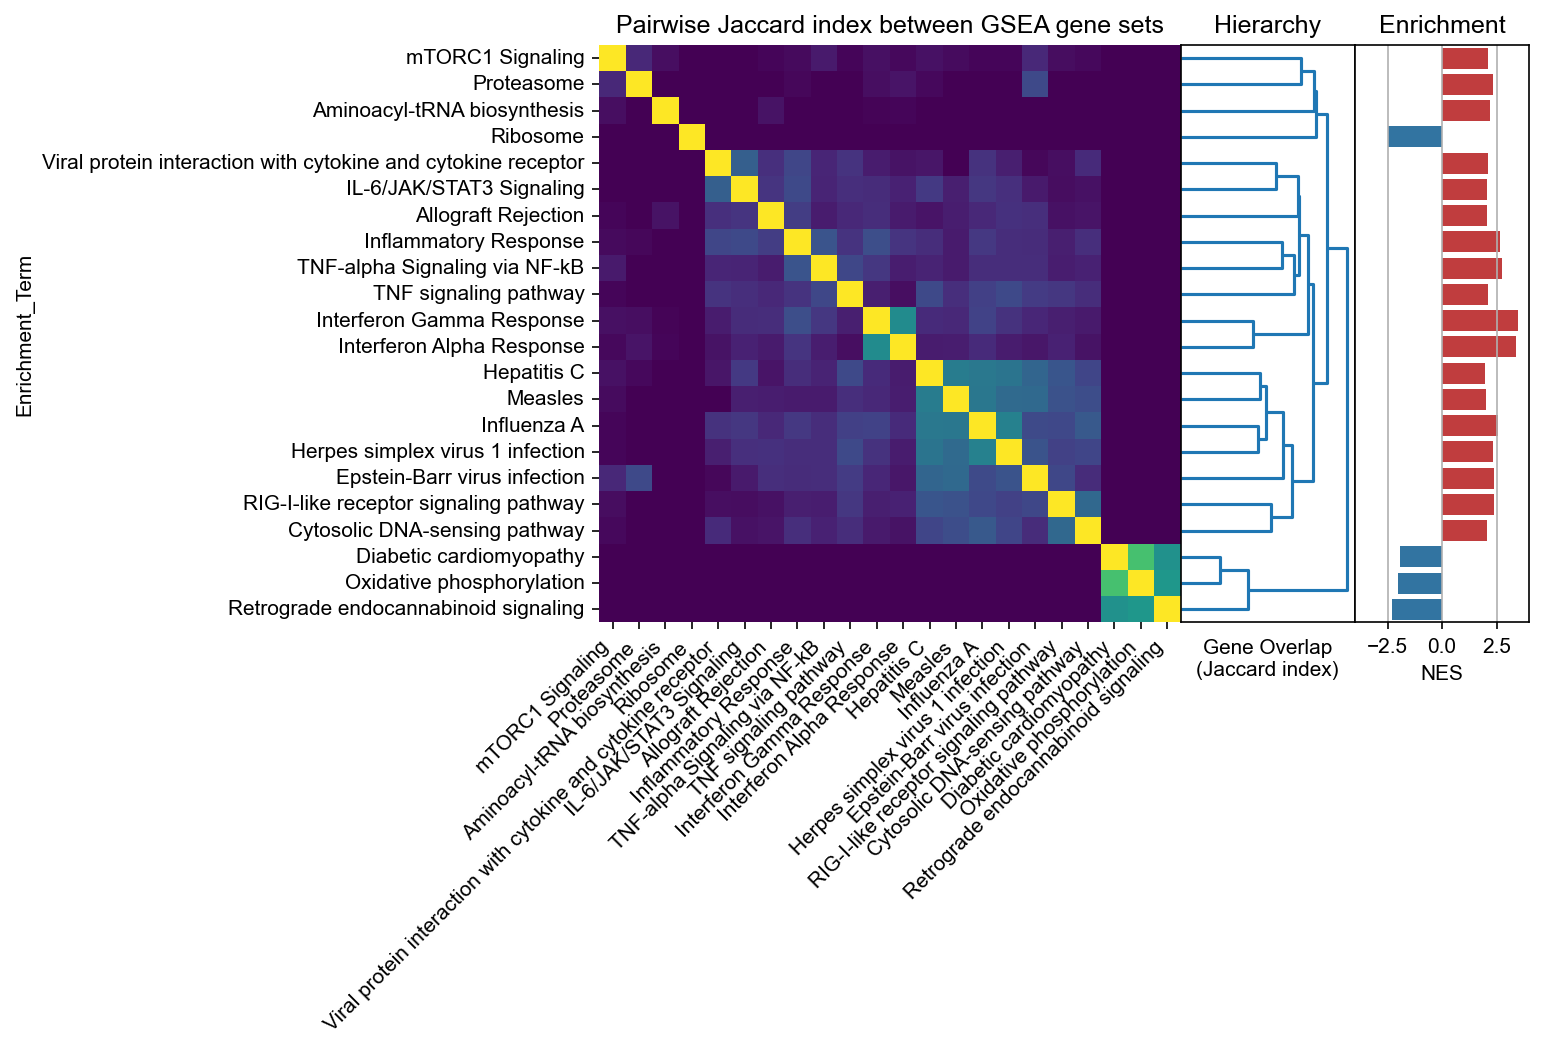

In [ ]:
from scipy.cluster import hierarchy
fig, axs = pl.subplots(1, 3, figsize=(5+3, 5), gridspec_kw={'width_ratios': [5, 1.5, 1.5], 'wspace': 0}, dpi=150)

ax = axs[1]
Z = hierarchy.linkage(J, method='average')
dn = hierarchy.dendrogram(Z, orientation='right', labels=J.index, leaf_font_size=8, color_threshold=0, ax=ax)
ax.set_xticks([])
ax.set_xlabel('Gene Overlap\n(Jaccard index)')
order=[x.get_text() for x in ax.get_yticklabels()[::-1]]  # use order from dendrogram
ax.set_yticks([])
ax.set_title('Hierarchy')

ax = axs[0]
sns.heatmap(J.loc[order, order], cmap='viridis', vmin=0, vmax=1, ax=ax, cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('')
ax.set_title('Pairwise Jaccard index between GSEA gene sets')

ax = axs[2]
sig_res['sign'] = sig_res['NES'].apply(lambda x: '+' if x>0 else '-')
sns.barplot(data=sig_res, ax=ax, order=order,
            y='Enrichment_Term', x='NES',
            hue='sign', dodge=False, palette=['tab:blue', 'tab:red'])
ax.legend([],[], frameon=False)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(True, axis='x')
ax.set_title('Enrichment')
ax.set_xlim(-4,4)
pl.savefig(figure_path / 'FigS5A_Endo_DC4_dynamics_GSEA_Supplement.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [ ]:
# Group gene sets by hierarchical clustering
manual_annotation = {
    'mTORC1 Signaling': 'Protein regulation',
    'Proteasome': 'Protein regulation',
    'Aminoacyl-tRNA biosynthesis': 'Protein regulation',
    'Ribosome': 'Ribosome',
    'Viral protein interaction with cytokine and cytokine receptor': 'Viral protein interaction with\ncytokine and cytokine receptor',
    'IL-6/JAK/STAT3 Signaling': 'IL-6/JAK/STAT3 Signaling',
    'Allograft Rejection': 'Allograft Rejection',
    'Inflammatory Response': 'TNF inflammatory response',
    'TNF-alpha Signaling via NF-kB': 'TNF inflammatory response',
    'TNF signaling pathway': 'TNF inflammatory response',
    'Interferon Gamma Response': 'Interferon response',
    'Interferon Alpha Response': 'Interferon response',
    'Hepatitis C': 'Virus infection',
    'Measles': 'Virus infection',
    'Influenza A': 'Virus infection',
    'Herpes simplex virus 1 infection': 'Virus infection',
    'Epstein-Barr virus infection': 'Virus infection',
    'RIG-I-like receptor signaling pathway': 'Virus sensing pathways',
    'Cytosolic DNA-sensing pathway': 'Virus sensing pathways',
    'Diabetic cardiomyopathy': 'OxPhos',
    'Oxidative phosphorylation': 'OxPhos',
    'Retrograde endocannabinoid signaling': 'OxPhos'
}

# set colors
groups = pd.unique(list(manual_annotation.values()))
color_groups = {g: f'C{i}' for i, g in enumerate(groups)}
color = [color_groups[manual_annotation[g]] for g in manual_annotation.keys()]
sig_res['cluster'] = [manual_annotation[g] for g in sig_res.Enrichment_Term]

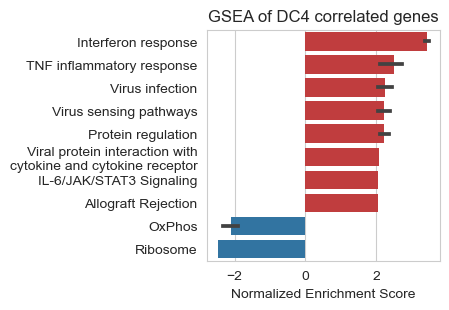

In [ ]:
sig_res.sort_values('NES', ascending=False, inplace=True)
with sns.axes_style("whitegrid"):
    fig, ax = pl.subplots(1, 1, figsize=[3, 3], dpi=100)
sns.barplot(data=sig_res, y='cluster', x='NES', ax=ax, hue='sign', dodge=False, 
            palette={'-': 'tab:blue', '+': 'tab:red'})
ax.legend_.remove()
ax.set_xlabel('Normalized Enrichment Score')
ax.set_ylabel('')
ax.set_title('GSEA of DC4 correlated genes')
pl.savefig(figure_path / 'Fig5E_Endo_DC4_dynamics_GSEA_grouped.pdf', bbox_inches='tight', dpi=300)
pl.show()

# Deprecated

## (DESEQ)

In [ ]:
deseq_path = Path('../results/DESeq2/infection/')
[x.name for x in deseq_path.glob('Endo*hamster*.csv')]

['Endothelial_Dwarfhamster_ld_COVID19_vs_healthy.csv',
 'Endothelial_Dwarfhamster_hd_COVID19_vs_healthy.csv',
 'Endothelial_Goldhamster_COVID19_vs_healthy.csv']

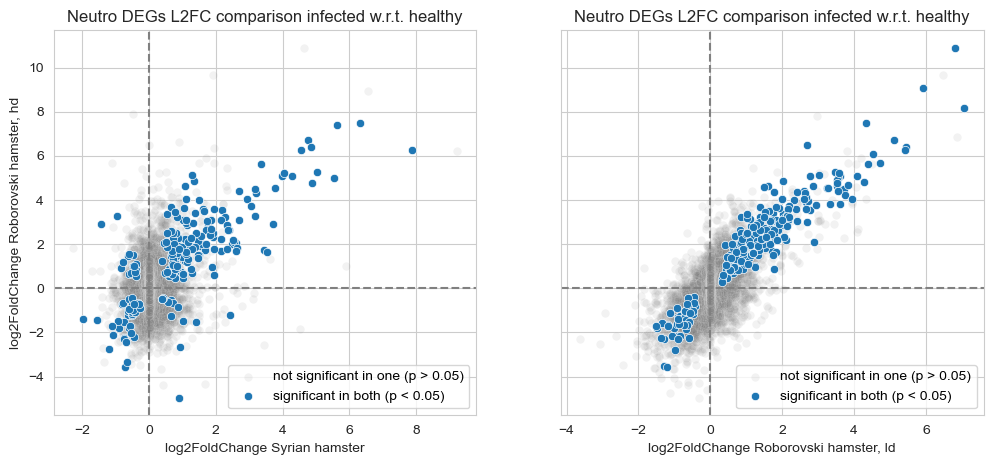

In [ ]:
y = 'Dwarfhamster_hd'
celltype_key = 'Endothelial'
alpha = 0.05

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, x in zip(axs, ['Goldhamster', 'Dwarfhamster_ld']):
    tab = pd.read_csv(deseq_path / f'{celltype_key}_{x}_COVID19_vs_healthy.csv', index_col=0)
    tab = tab[~tab.index.str.startswith('LOC')]

    tab_ = pd.read_csv(deseq_path / f'{celltype_key}_{y}_COVID19_vs_healthy.csv', index_col=0)
    tab_ = tab_[~tab_.index.str.startswith('LOC')]

    tabo = pd.concat({x: tab, y: tab_}, axis=1)
    tabo = tabo[~(tabo[(x, 'padj')].isna() | tabo[(y, 'padj')].isna())]
    tabo['significant'] = (tabo[(x, 'padj')] < alpha) & (tabo[(y, 'padj')] < alpha)

    scatter_kwargs = dict(x=(x, 'log2FoldChange'), y=(y, 'log2FoldChange'), ax=ax)
    sns.scatterplot(data=tabo[~tabo.significant], 
                    alpha=0.1, color='grey', 
                    label=f'not significant in one (p > {alpha})',
                    **scatter_kwargs)
    sns.scatterplot(data=tabo[tabo.significant], 
                    label=f'significant in both (p < {alpha})',
                    **scatter_kwargs)
    ax.set_xlabel(f'log2FoldChange {sanitize_name(x)}')
    ax.set_ylabel(f'log2FoldChange {sanitize_name(y)}')
    ax.set_title('Neutro DEGs L2FC comparison infected w.r.t. healthy')
    ax.axhline(0, color='grey', linestyle='--')
    ax.axvline(0, color='grey', linestyle='--')
pl.show()

In [ ]:
genes = list(tabo.index[(tabo[(x, 'log2FoldChange')] > 0) & (tabo[(y, 'log2FoldChange')] < 0)])
res = gp.enrichr(gene_list=genes, gene_sets=['MSigDB_Hallmark_2020'], organism='Mouse')
res2d = res.res2d
res2d = res2d[res2d['Adjusted P-value'] < 0.2]
res2d

Gene_set                             Term Overlap   P-value  \
0  MSigDB_Hallmark_2020                Androgen Response   2/100  0.001862   
1  MSigDB_Hallmark_2020                   UV Response Dn   2/144  0.003812   
2  MSigDB_Hallmark_2020        Oxidative Phosphorylation   2/200  0.007218   
3  MSigDB_Hallmark_2020                 mTORC1 Signaling   2/200  0.007218   
4  MSigDB_Hallmark_2020  Reactive Oxygen Species Pathway    1/49  0.031395   
5  MSigDB_Hallmark_2020                      Pperoxisome   1/104  0.065549   
6  MSigDB_Hallmark_2020             Bile Acid Metabolism   1/112  0.070424   
7  MSigDB_Hallmark_2020            Fatty Acid Metabolism   1/158  0.097998   
8  MSigDB_Hallmark_2020                  Apical Junction   1/200  0.122513   
9  MSigDB_Hallmark_2020              Allograft Rejection   1/200  0.122513   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.018045            0                     0   36.899814   
1          0.018045            0                     0   25.409731   
2          0.018045            0                     0   18.171717   
3          0.018045            0                     0   18.171717   
4          0.062790            0                     0   34.616319   
5          0.100605            0                     0   16.087379   
6          0.100605            0                     0   14.921922   
7          0.122497            0                     0   10.525478   
8          0.122513            0                     0    8.286432   
9          0.122513            0                     0    8.286432   

   Combined Score          Genes  
0      231.947593  INSIG1;DHCR24  
1      141.522628  EFEMP1;INSIG1  
2       89.607706  NDUFB4;NDUFB3  
3       89.607706  INSIG1;DHCR24  
4      119.810689         NDUFB4  
5       43.837331         DHCR24  
6       39.591244         DHCR24  
7       24.448667         DHCR24  
8       17.397666         INSIG1  
9       17.397666          MTIF2

In [ ]:
genes = list(tabo.index[(tabo[(x, 'log2FoldChange')] < 0) & (tabo[(y, 'log2FoldChange')] > 0)])
res = gp.enrichr(gene_list=genes, gene_sets=['MSigDB_Hallmark_2020'], organism='Mouse')
res2d = res.res2d
res2d = res2d[res2d['Adjusted P-value'] < 0.2]
res2d

Gene_set                      Term Overlap   P-value  \
0  MSigDB_Hallmark_2020           Mitotic Spindle   2/199  0.010785   
1  MSigDB_Hallmark_2020              Adipogenesis   2/200  0.010888   
2  MSigDB_Hallmark_2020  IL-6/JAK/STAT3 Signaling    1/87  0.067399   
3  MSigDB_Hallmark_2020                 Apoptosis   1/161  0.121351   
4  MSigDB_Hallmark_2020      IL-2/STAT5 Signaling   1/199  0.147905   
5  MSigDB_Hallmark_2020   Estrogen Response Early   1/200  0.148593   
6  MSigDB_Hallmark_2020       Allograft Rejection   1/200  0.148593   
7  MSigDB_Hallmark_2020     Inflammatory Response   1/200  0.148593   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.043554            0                     0   14.348803   
1          0.043554            0                     0   14.275613   
2          0.148593            0                     0   15.424806   
3          0.148593            0                     0    8.260000   
4          0.148593            0                     0    6.661953   
5          0.148593            0                     0    6.628141   
6          0.148593            0                     0    6.628141   
7          0.148593            0                     0    6.628141   

   Combined Score             Genes  
0       64.994922  CDC42EP2;ARHGEF2  
1       64.526557     IFNGR1;ATP1B3  
2       41.602646            IFNGR1  
3       17.420917            IFNGR1  
4       12.732227            IFNGR1  
5       12.636822             P2RY2  
6       12.636822            IFNGR1  
7       12.636822             P2RY2

## (score vs DC4 smoothed)

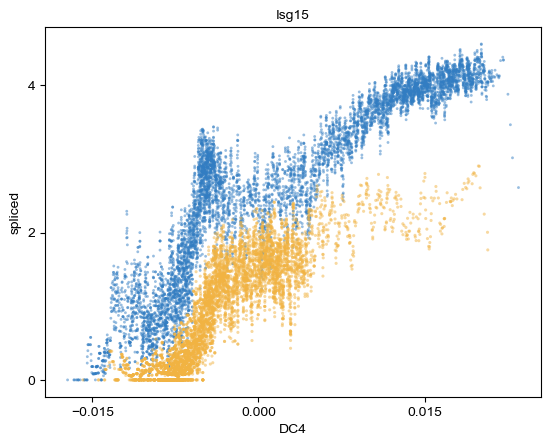

In [242]:
n_convolve = 10
gene = 'Isg15'
ax = None
for organism in ['Dwarfhamster', 'Goldhamster']:
    ax = scv.pl.scatter(sdata[sdata.obs.organism==organism], x='DC4', y=gene, color=organism_colors[organism], n_convolve=n_convolve,
                   legend_loc='best', ncols=5, layer='Ms', show=False, ax=ax, alpha=0.5)

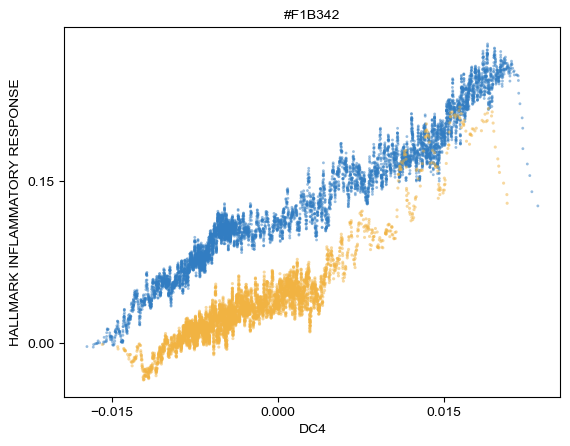

In [121]:
n_convolve = 20
gene = 'HALLMARK_INFLAMMATORY_RESPONSE'
ax = None
for organism in ['Dwarfhamster', 'Goldhamster']:
    ax = scv.pl.scatter(sdata[sdata.obs.organism==organism], x='DC4', y=gene, color=organism_colors[organism], n_convolve=n_convolve,
                   legend_loc='best', ncols=5, layer='Ms', show=False, ax=ax, alpha=0.5)

In [29]:
import statsmodels.api as sm
def lowess_with_confidence_bounds(
    x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None
):
    """
    # https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

In [69]:
eval_x = np.linspace(dmin, dmax, 30)
smoothed, bottom, top = lowess_with_confidence_bounds(
    data[kwargs['y']][mask], 
    data[kwargs['x']][mask], 
    eval_x, 
    N=100,
    lowess_kw={"frac": 2/3})
x_lowess = eval_x
y_lowess = smoothed

In [6]:
i=4
dmin = np.min(sdata.obsm['X_diffmap'][:, i])
dmax = np.max(sdata.obsm['X_diffmap'][:, i])
key = 'HALLMARK_INFLAMMATORY_RESPONSE'
kwargs = dict(legend=False, s=10, palette=organism_dosage_colors, x=f'DC{i}', y=key, hue='organism_dosage')

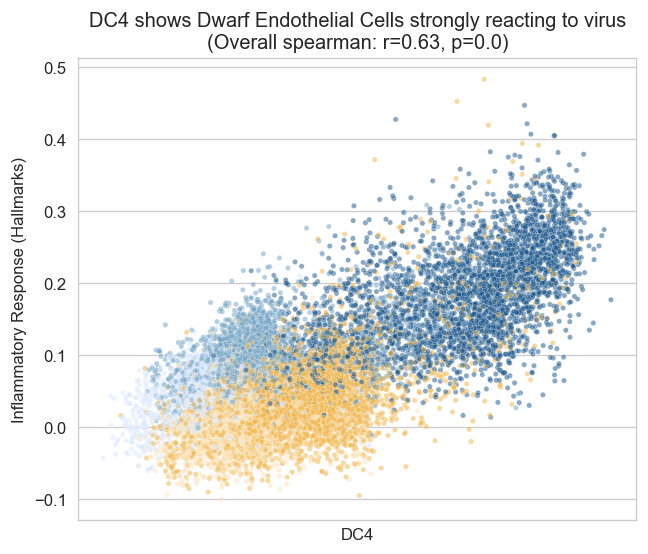

In [8]:

sdata.obs[f'DC{i}'] = sdata.obsm['X_diffmap'][:,i]
with sns.axes_style('whitegrid'): 
    fig, ax = pl.subplots(1,1, figsize=[6,5], dpi=120)
ax=ax
data = sdata.obs.copy().sample(frac=1)  # shuffle
# scatter
# sns.scatterplot(data=data, zorder=1,
#                 ax=ax, alpha=0.5, **kwargs)
sns.scatterplot(data=data, zorder=1,
                ax=ax, alpha=0.5, **kwargs)
# regression
r, p = spearmanr(sdata.obs[f'DC{i}'], sdata.obs[key])

# plot visuals
ax.set_title(f'DC{i} shows Dwarf Endothelial Cells strongly reacting to virus\n(Overall spearman: r={np.round(r,2)}, p={np.round(p,10)})')
ax.set_ylabel('Inflammatory Response (Hallmarks)')
ax.set_xticks([])
ax.set_xlabel('DC4')

# pl.savefig(figure_path / 'Endo_DC4_corr_INFLAMMATION_and_virus.pdf', bbox_inches='tight', dpi=300)
# pl.savefig(figure_path / 'Endo_DC4_corr_INFLAMMATION_and_virus.png', bbox_inches='tight', dpi=300)
pl.show()

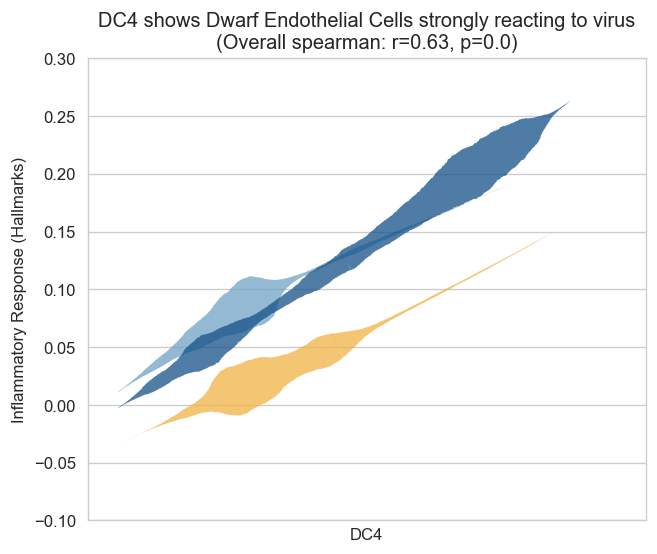

In [69]:
N_eval = 1000  # x-axis resolution for density (1000 is good)
N_eval_ci = 100  # x-axis resolution for confidence interval (100 is good)
lowess_frac = 1  # lowess fraction (2/3 is good)
kernel_width = 50  # density covolution kernel density width (20 is good)
conf_interval = 0.95  # confidence interval
add_ci = False

sdata.obs[f'DC{i}'] = sdata.obsm['X_diffmap'][:,i]
with sns.axes_style('whitegrid'): 
    fig, ax = pl.subplots(1,1, figsize=[6,5], dpi=120)
ax=ax
data = sdata.obs.copy()
for organism, dosage in zip(['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose']):
    mask = (data['organism']==organism) & (data['dosage'].isin([dosage, 'no dose']))
    color = organism_dosage_colors[f'{organism}_{dosage}']

    # lowess regression
    x_lowess = np.linspace(dmin, dmax, N_eval)
    y_lowess = sm.nonparametric.lowess(
            exog=data[kwargs['x']][mask], endog=data[kwargs['y']][mask], 
            xvals=x_lowess, frac=lowess_frac
        )
    
    # calculate CI
    if add_ci:
        x_lowess_ci = np.linspace(dmin, dmax, N_eval_ci)
        _, bottom_ci, top_ci = lowess_with_confidence_bounds(
            data[kwargs['x']][mask], 
            data[kwargs['y']][mask], 
            x_lowess_ci, 
            N=N_eval_ci,
            conf_interval=conf_interval,
            lowess_kw={"frac": lowess_frac})
        # plot lowess CIs
        pl.fill_between(x_lowess_ci, bottom_ci, top_ci, alpha=0.2, color=color, zorder=2)
    
    # widths are calculated as binned density, then convolved across fixed width uniform kernel
    h = np.histogram(sdata.obsm['X_diffmap'][mask, i], 
                    range=[dmin, dmax], bins=N_eval)[0]
    h = np.convolve(h, np.ones(kernel_width)/kernel_width, mode='same')
    
    # plot lowess regression line with cell densitites as widths
    from matplotlib.collections import LineCollection
    max_width = 30
    min_width = 1
    widths = (h - np.min(h)) / np.max(h) * (max_width - min_width) + min_width
    points = np.array([x_lowess, y_lowess]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, linewidths=widths, color=color, zorder=1)
    ax.add_collection(lc)
    ax.set_xlim(-0.02, 0.03)
    ax.set_ylim(-0.1, 0.3)

# plot visuals
ax.set_title(f'DC{i} shows Dwarf Endothelial Cells strongly reacting to virus\n(Overall spearman: r={np.round(r,2)}, p={np.round(p,10)})')
ax.set_ylabel('Inflammatory Response (Hallmarks)')
ax.set_xticks([])
ax.set_xlabel('DC4')

pl.savefig(figure_path / 'Endo_DC4_corr_INFLAMMATION_and_virus_lowess.pdf', bbox_inches='tight', dpi=300)
pl.savefig(figure_path / 'Endo_DC4_corr_INFLAMMATION_and_virus_lowess.png', bbox_inches='tight', dpi=300)
pl.show()

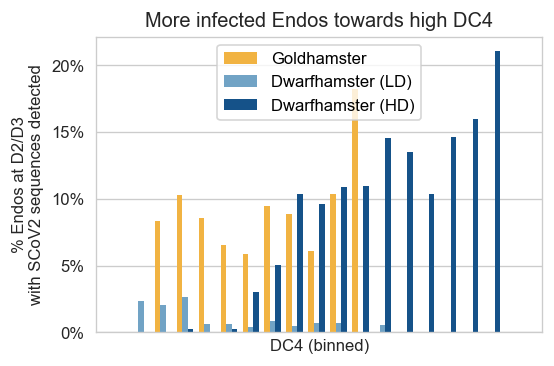

In [60]:
i=4
scale = 0.8
n_bins = 20
min_cells_per_bin = 5
dmin = np.min(sdata.obsm['X_diffmap'][:, i])
dmax = np.max(sdata.obsm['X_diffmap'][:, i])

h_virus = np.histogram(sdata.obsm['X_diffmap'][(sdata.obs.SCoV2_detected==True) & (sdata.obs.organism_dosage=='Dwarfhamster_low dose') & (sdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)[0]
h = np.histogram(sdata.obsm['X_diffmap'][(sdata.obs.dosage!='no dose') & (sdata.obs.organism=='Dwarfhamster') & (sdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)[0]
frac_infected_dwarf_ld = (h_virus / h) * (h>min_cells_per_bin).astype(float)

h_virus = np.histogram(sdata.obsm['X_diffmap'][(sdata.obs.SCoV2_detected==True) & (sdata.obs.organism_dosage=='Dwarfhamster_high dose') & (sdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)[0]
h = np.histogram(sdata.obsm['X_diffmap'][(sdata.obs.dosage!='no dose') & (sdata.obs.organism=='Dwarfhamster') & (sdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)[0]
frac_infected_dwarf_hd = (h_virus / h) * (h>min_cells_per_bin).astype(float)

h_virus = np.histogram(sdata.obsm['X_diffmap'][(sdata.obs.SCoV2_detected==True) & (sdata.obs.organism!='Dwarfhamster') & (sdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)[0]
h = np.histogram(sdata.obsm['X_diffmap'][(sdata.obs.dosage!='no dose') & (sdata.obs.organism!='Dwarfhamster') & (sdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)[0]
frac_infected_gold = (h_virus / h) * (h>min_cells_per_bin).astype(float)

from matplotlib.ticker import PercentFormatter
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[6*scale,4*scale], dpi=120)
width = 0.25
ax.bar(np.arange(n_bins)-width, frac_infected_gold, color=organism_dosage_colors['Goldhamster_high dose'], width=width, label='Goldhamster')
ax.bar(np.arange(n_bins), frac_infected_dwarf_ld, color=organism_dosage_colors['Dwarfhamster_low dose'], width=width, label='Dwarfhamster (LD)')
ax.bar(np.arange(n_bins)+width, frac_infected_dwarf_hd, color=organism_dosage_colors['Dwarfhamster_high dose'], width=width, label='Dwarfhamster (HD)')
ax.set_xticks([])
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylabel('% Endos at D2/D3\nwith SCoV2 sequences detected')
ax.legend()
ax.set_xlabel('DC4 (binned)')
ax.set_title('More infected Endos towards high DC4')
pl.savefig(figure_path / f'Endos_DC4_perc_infected.pdf', bbox_inches='tight', dpi=300)
pl.show()

## (Scores)

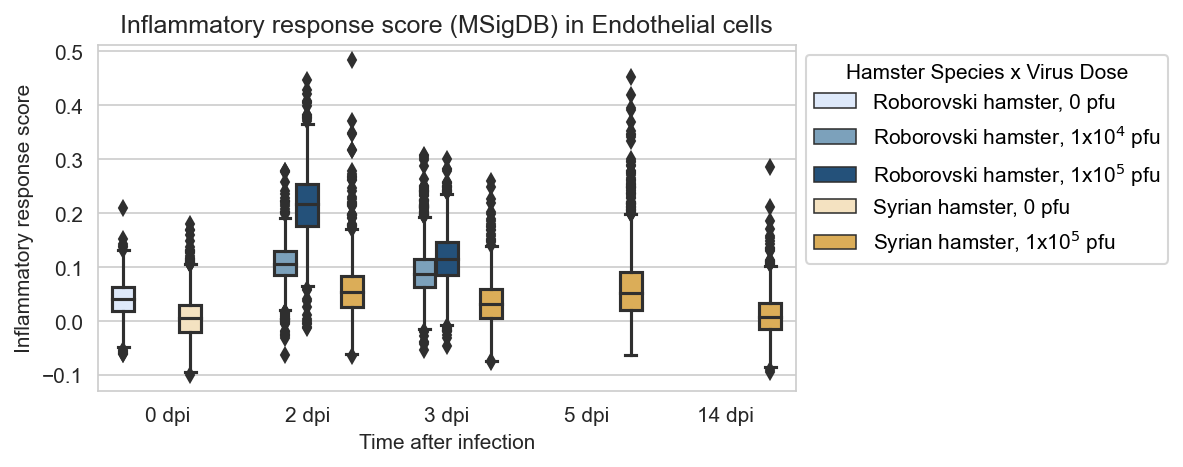

In [ ]:
df = mdata.obs.copy()
key = 'HALLMARK_INFLAMMATORY_RESPONSE'
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(6,3), dpi=150)
sns.boxplot(x='Time', y=key, data=df, palette=Organism_Dosage_colors, hue='Organism_Dosage', ax=ax)
ax.legend_.set_title('Hamster Species x Virus Dose')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
ax.set_title('Inflammatory response score (MSigDB) in Endothelial cells')
ax.set_xlabel('Time after infection')
ax.set_ylabel('Inflammatory response score')
pl.show()

## (PD1)

In [8]:
i = 4
sdata.obs[f'DC{i}'] = sdata.obsm['X_diffmap'][:,i]
sdata.obs['replicate'] = [x[2] for x in sdata.obs.hamster]

# Binarize DC
range_percs = [1,99]
n_bins=50
X = sdata.obs[f'DC{i}']
xmin = np.percentile(X, range_percs[0])
xmax = np.percentile(X, range_percs[1])
numbers, bins = np.histogram(X, range=[xmin, xmax], bins=n_bins)

# Linearly correlate each gene with DC1
df4 = lin_corr_adata(sdata, sdata.obsm['X_diffmap'][:,i], mdata.var_names, method='spearman')

100%|██████████| 12855/12855 [00:19<00:00, 659.51it/s]


Text(0.5, 0, 'Endo DC4')

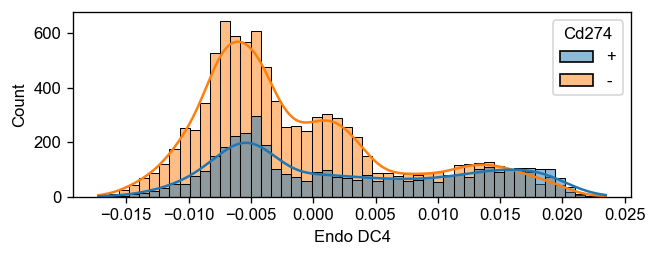

In [11]:
df = sdata.obs.copy()
y=sdata[:, 'Cd274'].X.A
df['Cd274'] = ['+' if x > 0 else '-' for x in y]
pl.subplots(figsize=[6,2], dpi=120)
sns.histplot(data=df, x='DC4', hue='Cd274', kde=True, bins=50)
pl.xlabel('Endo DC4')

Text(0.5, 0, 'Endo DC4')

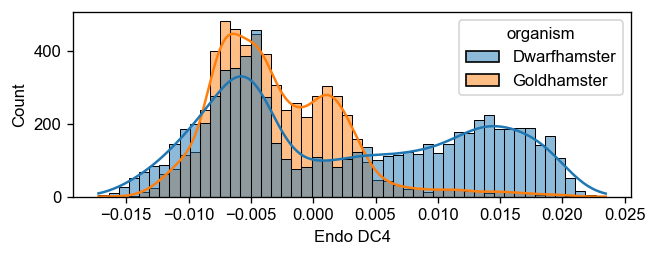

In [12]:
df = sdata.obs.copy()
y=sdata[:, 'Cd274'].X.A
df['Cd274'] = ['+' if x > 0 else '-' for x in y]
pl.subplots(figsize=[6,2], dpi=120)
sns.histplot(data=df, x='DC4', hue='organism', kde=True, bins=50)
pl.xlabel('Endo DC4')

In [14]:
N = 5  # number of top and bottom correlating genes to plot
top = list(df4.index[:N])
bot = list(df4.index[-N:])

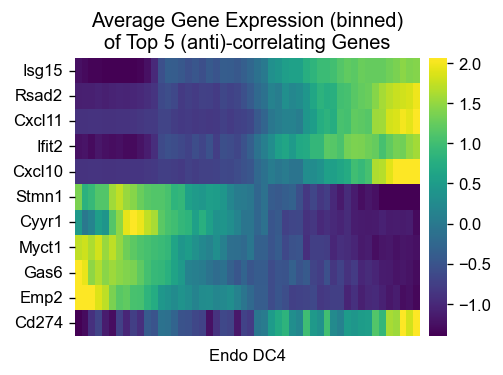

In [18]:
genes = top + bot + ['Cd274']
binned_mean_exp = pd.DataFrame(index=genes, columns=np.arange(n_bins))
for i in range(n_bins):
    Y = sdata[(X>bins[i]) & (X<bins[i+1]), genes].X.A
    binned_mean_exp[i] = np.mean(Y, axis=0)

from scipy.stats import zscore
T_raw = binned_mean_exp.T.sort_index(ascending=True).T
T = zscore(T_raw, axis=1)

fig, axs = pl.subplots(1, 2, figsize=[4,3], dpi=120, gridspec_kw={'width_ratios': [10, .5], 'wspace': 0.05})
sns.heatmap(T, cmap='viridis', robust=True, ax=axs[0], cbar_ax=axs[1], cbar_kws={'orientation': "vertical"})
axs[0].set_xticks([])
axs[0].set_xlabel('Endo DC4')
axs[0].set_title(f'Average Gene Expression (binned)\nof Top {N} (anti)-correlating Genes')
pl.show()

Text(0.5, 1.0, 'Cd274 expression across Endothelial cells over time')

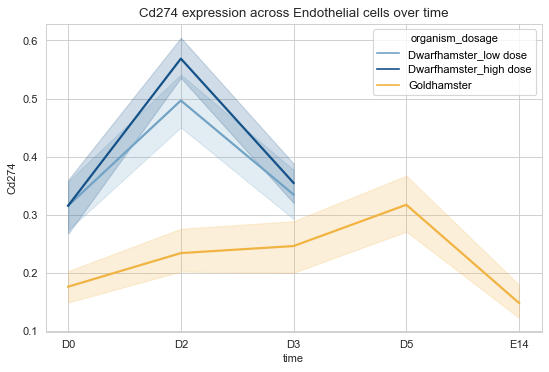

In [21]:
palette = {'Goldhamster': organism_colors['Goldhamster'],
           'Dwarfhamster_low dose': organism_dosage_colors['Dwarfhamster_low dose'],
           'Dwarfhamster_high dose': organism_dosage_colors['Dwarfhamster_high dose'],
}
axs = plot_timecourse_dose(sdata, ['Cd274'], x='time', 
                     ci=99, markers=True, linewidth=2, palette=palette)
pl.title('Cd274 expression across Endothelial cells over time')

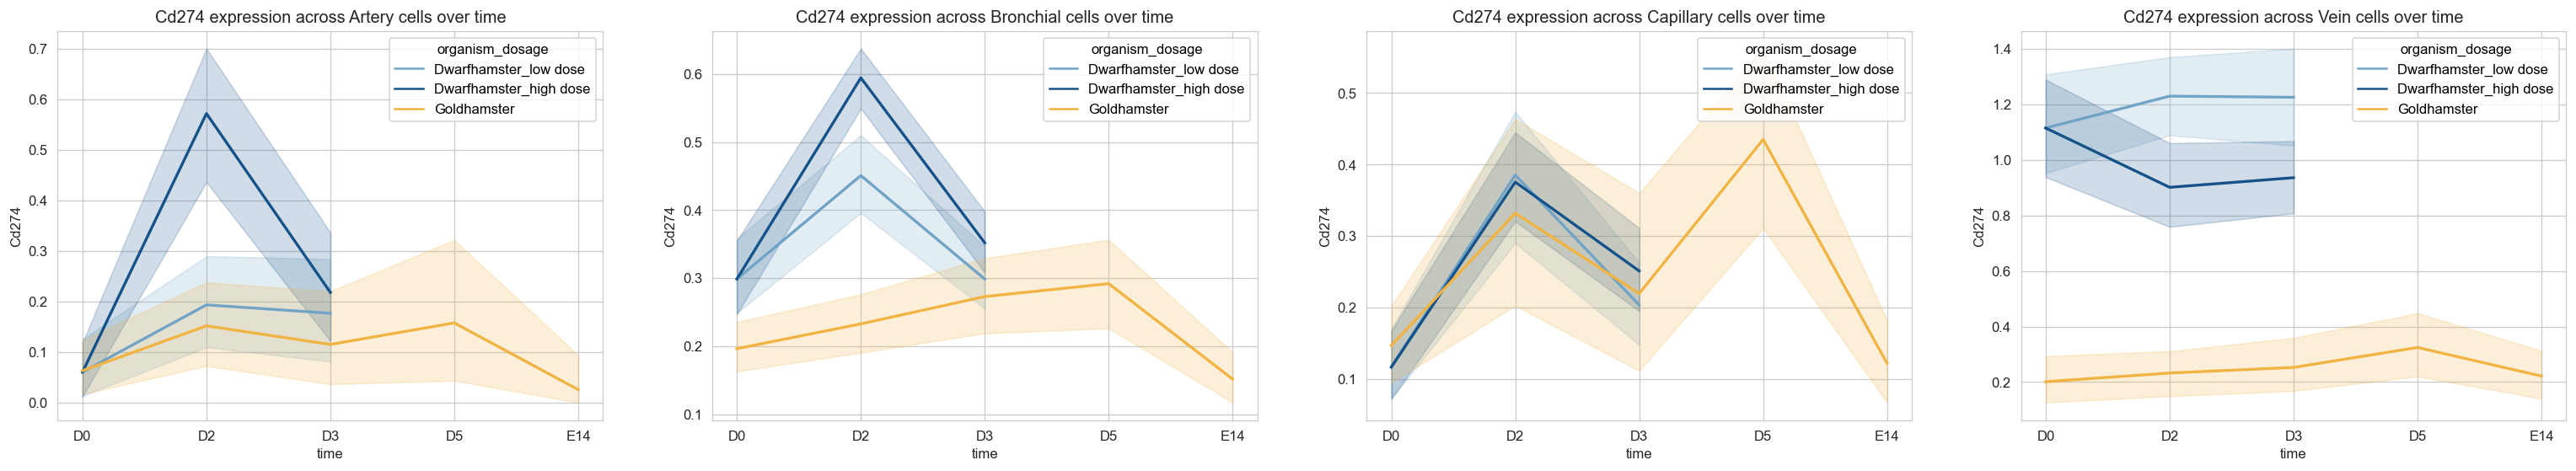

In [46]:
types = ['Artery', 'Bronchial', 'Capillary', 'Vein']
with sns.axes_style('whitegrid'):
    axs = pl.subplots(1, len(types), figsize=[8*4,5], dpi=120)[-1]
for ax, subtype in zip(axs, types):
    plot_timecourse_dose(sdata[sdata.obs.celltype.isin([subtype])], ['Cd274'], x='time', 
                        ci=99, markers=True, linewidth=2, palette=palette, ax=ax)
    ax.set_title(f'Cd274 expression across {subtype} cells over time')
pl.show()